# Exploring Wikipedia clickstream data: English Wiki in December 2018    

## Network Analysis

### 1. Introduction  
This notebook contains network analysis of the English Wikipedia clickstream dataset for December 2018.  
This is the 4th part of a project about the usage patterns of Wikipedia.  
The preceding parts are:  
1. [Data quality analysis of available datasets](data_quality_analysis.ipynb)  
2. [Exploratory data analysis of the English Wikipedia clickstream dataset for December 2018](English_Wikipedia_EDA.ipynb)  
3. [Graph modeling of the English Wikipedia clickstream dataset for December 2018](English_Wikipedia_graph_modeling_AWS.ipynb)

In this notebook, we'll use network analysis techniques to explore the English Wikipedia clickstream data as a graph, find influential articles, detect article communities, visualize the graph, and derive an aggregated graph of topic communities.

#### Notebook contents:  

1. [Introduction](#1.-Introduction)  
2. [Notebook setup](#2.-Notebook-setup)  
   = [Connect to neo4j](#Connect-to-neo4j)  
   = [Install neo4j's Apoc procedures](#Install-neo4j's-Apoc-procedures)  
   = [Install neo4j's Algo procedures](#Install-neo4j's-Algo-procedures)
3. [Analysis](#3.-Analysis)  
   3.1 [Describing the Wikipedia clickstream graph](#3.1-Describing-the-Wikipedia-clickstream-graph)  
      = [Node and edge counts](#Node-and-edge-counts)  
      = [Dyad census](#Dyad-census)  
      = [Network density](#Network-density)  
   3.2 [Degree centrality](#3.2-Degree-centrality)  
      = [Degree stats](#Degree-stats)  
      = [Top degree nodes](#Top-degree-nodes)  
      = [Article-level traffic stats](#Article-level-traffic-stats)  
      = [Top traffic articles, by traffic type](#Top-traffic-articles,-by-traffic-type)  
   3.3 [Weakly connected components / Union find](#3.3-Weakly-connected-components-/-Union-find)  
   3.4 [ArticleRank centrality](#3.4-ArticleRank-centrality)  
   3.5 [Community detection](#3.5-Community-detection)  
      = [Louvain community stats](#Louvain-community-stats)  
      = [Communities visualization](#Communities-visualization)  
      = [Comparing community graphs](#Comparing-community-graphs)  
      = [Deriving a network of communities](#Deriving-a-network-of-communities)  
4. [Summary](#4.-Summary)
5. [Next steps](#5.-Next-steps)

### 2. Notebook setup  

#### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


from py2neo import authenticate, Graph, Node, Relationship


import os
import csv
import pickle

from time import sleep
from timeit import default_timer as timer
from datetime import datetime

from IPython.display import display, HTML

# custom general helper functions for this project
import custom_utils as cu
import importlib


In [2]:
# reload imports as needed
importlib.reload(cu);

#### Settings

In [3]:
# Customize matplotlib default settings
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
# set up Pandas options
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.options.display.float_format = '{:.2f}'.format

#### Connect to neo4j

In [5]:
n4j_cred = cu.read_n4jpass()

# set up authentication parameters
authenticate("localhost:7474", n4j_cred["user"], n4j_cred["password"])

# connect to authenticated graph database
graph = Graph("http://localhost:7474/db/data/")

# test query
r = graph.data('CALL db.indexes;')
pd.DataFrame(r)

,description,failureMessage,id,indexName,progress,properties,provider,state,tokenNames,type
0,INDEX ON :Article(title),,1,index_1,100.00,[title],"{'version': '1.0', 'key': 'native-btree'}",ONLINE,[Article],node_unique_property


#### Install neo4j's Apoc procedures  
Instructions: https://neo4j-contrib.github.io/neo4j-apoc-procedures/#_installation_in_neo4j_server_docker  
**Note:** The first two digits in neo4j and Apoc versions must match, check the compatibility matrix [here](https://github.com/neo4j-contrib/neo4j-apoc-procedures#version-compatibility-matrix) and download the appropriate Apoc version, or go to https://github.com/neo4j-contrib/neo4j-apoc-procedures/releases/ to get the latest Apoc release at the top.

#### Install neo4j's Algo procedures  
Instructions: https://neo4j.com/docs/graph-algorithms/current/introduction/#_installation 

### 3. Analysis

#### 3.1 Describing the Wikipedia clickstream graph  

##### Node and edge counts  

In [6]:
start_time = timer()

# number of articles
q = """
    MATCH (a:Article)
    RETURN count(a) as articles_count;
    """
r = graph.data(q)
descriptive_stats = pd.DataFrame(r)

# number of articles that are not linked to other articles, i.e. singletons
q = """
    MATCH (a:Article)
    WHERE size((a)-[]-()) = 0
    RETURN 
        count(a) as singleton_articles_count;
 """
r = graph.data(q)
descriptive_stats = pd.concat([descriptive_stats, pd.DataFrame(r)], axis=1)

# number of directed edges, and total traffic volume in the graph
q = """
    MATCH ()-[r]->()
    RETURN 
        count(r) as relationships_count,
        sum(r.traffic) as total_traffic;
 """
r = graph.data(q)
descriptive_stats = pd.concat([descriptive_stats, pd.DataFrame(r)], axis=1)

# number of directed LINK_TO edges, and LINK_TO traffic volume
q = """
    MATCH ()-[r:LINK_TO]->()
    RETURN 
        count(r) as link_edges_count,
        sum(r.traffic) as link_edges_traffic;
 """
r = graph.data(q)
descriptive_stats = pd.concat([descriptive_stats, pd.DataFrame(r)], axis=1)

# number of directional SEARCH_FOR edges, and SEARCH_FOR traffic volume
q = """
    MATCH ()-[r:SEARCH_FOR]->()
    RETURN 
        count(r) as search_edges_count,
        sum(r.traffic) as search_edges_traffic;
 """
r = graph.data(q)
descriptive_stats = pd.concat([descriptive_stats, pd.DataFrame(r)], axis=1)


cu.printRunTime(start_time)

descriptive_stats

Runtime: 1.54 min



,articles_count,singleton_articles_count,relationships_count,total_traffic,link_edges_count,link_edges_traffic,search_edges_count,search_edges_traffic
0,5185699,2413205,18361180,1737027807,17851501,1718277936,509679,18749871


In [7]:
# pickle the output
myoutfile = "pickles/en_1218_descriptive_network_stats.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(descriptive_stats, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_descriptive_network_stats.pkl


In [8]:
# unpickle
with open("pickles/en_1218_descriptive_network_stats.pkl", 'rb') as picklefile: 
    descriptive_stats = pickle.load(picklefile)

descriptive_stats

,articles_count,singleton_articles_count,relationships_count,total_traffic,link_edges_count,link_edges_traffic,search_edges_count,search_edges_traffic
0,5185699,2413205,18361180,1737027807,17851501,1718277936,509679,18749871


##### Dyad census  
A dyad is any pair of nodes in a graph.  
These pairs of nodes can be classified by the connections between them:  
- **Null**: a pair of nodes with no connections between them.  
- **Asymmetric**: a pair of nodes where one node has a directed relationship with the other, but not vice versa.  
- **Mutual**: a pair of nodes where each node has a directed relationship with the other.  

In our Wikipedia clickstream graph model, we have two kinds of relationships, LINK_TO and SEARCH_FOR. By the definition those relationships, the SEARCH_FOR relationship is complemantary to LINK_TO, in that it can only happen when there is no LINK_TO relationship going in the same direction. But we can have LINK_TO and SEARCH_FOR relationships going in opposite directions in a dyad.  
So, if we choose to distinguish between the two relationship types for dyad census, we have a few extra dyad classifications to consider:  
- **Null**: same as above.  
- **Asymmetric links**: one node links to the other, but no connection vice versa.  
- **Asymmetric searches**: one node had a search for the other, but no connection vice versa. 
- **Mutual links**: each node links to the other.
- **Mutual searches**: each node has a search for the other.
- **Complementary**: A links to B, and B has a search for A.  

To get the dyad census for any relationship type, we can just sum across the asymmetric classes to get the overall asymmetric dyad class count, and sum across the mutual and complementary classes to get the overall mutual dyad class count. The null class remains the same.

In [7]:
N = descriptive_stats.articles_count.values[0]

#number of all possible directed edges
possible_dir_edges = N * (N - 1)
print("Number of possible directed edges:", "{:,}".format(possible_dir_edges) )

#number of all possible undirected edges
possible_undir_edges = int(possible_dir_edges / 2)
print("Number of possible undirected edges:", format(possible_undir_edges, ',') )

Number of possible directed edges: 26,891,468,932,902
Number of possible undirected edges: 13,445,734,466,451


In [48]:
# number of mutual LINK_TO relationships

print("Started running at", datetime.now(), "UTC")
start_time = timer()

q = """
    match p=(a)-[r1:LINK_TO]->(b)-[r2:LINK_TO]->(a)
    return count(p)/2 as count;
 """
r = graph.data(q)

cu.printRunTime(start_time)
pd.DataFrame(r)

Started running at 2019-02-20 02:24:37.869997 UTC


Runtime: 4.37 min



,count
0,2959959


In [61]:
dyad_census = pd.DataFrame(data=r, index=["mutual links"], columns=["count"], dtype="int64")
dyad_census

,count
mutual links,2959959


In [75]:
# number of mutual SEARCH_FOR relationships

print("Started running at", datetime.now(), "UTC")
start_time = timer()

q = """
    MATCH p=(a)-[r1:SEARCH_FOR]->(b)-[r2:SEARCH_FOR]->(a)
    RETURN count(p)/2 as count;
 """
r = graph.data(q)

cu.printRunTime(start_time)

dyad_census = pd.concat([dyad_census, pd.DataFrame(data=r, index=["mutual searches"], columns=["count"], dtype="int64")])
dyad_census

Started running at 2019-02-20 02:52:07.423830 UTC


Runtime: 0.21 min



,count
mutual links,2959959
mutual searches,33236


In [76]:
# number of complementary LINK_TO/SEARCH_FOR relationships

print("Started running at", datetime.now(), "UTC")
start_time = timer()

q = """
    MATCH p=(a)-[:LINK_TO]->(b)-[:SEARCH_FOR]->(a)
    RETURN count(p) as count;
 """
r = graph.data(q)

cu.printRunTime(start_time)

dyad_census = pd.concat([dyad_census, pd.DataFrame(data=r, index=["complementary"], columns=["count"], dtype="int64")])
dyad_census

Started running at 2019-02-20 02:57:49.137651 UTC


Runtime: 0.27 min



,count
mutual links,2959959
mutual searches,33236
complementary,85226


In [93]:
# We can derive the remaining counts from previous calculations.
dyad_census.loc["asymmetric links"] = descriptive_stats.link_edges_count.values[0] \
                                      - dyad_census.at["mutual links", "count"] * 2 \
                                      - dyad_census.at["complementary", "count"]
    
dyad_census.loc["asymmetric searches"] = descriptive_stats.search_edges_count.values[0] \
                                       - dyad_census.at["mutual searches", "count"] * 2 \
                                       - dyad_census.at["complementary", "count"]
        
dyad_census.loc["null"] = possible_undir_edges - (  dyad_census.at["mutual links", "count"]
                                                  + dyad_census.at["mutual searches", "count"]
                                                  + dyad_census.at["complementary", "count"]
                                                  + dyad_census.at["asymmetric links", "count"]
                                                  + dyad_census.at["asymmetric searches", "count"]
                                                 )

dyad_census["proportion"] = dyad_census["count"] / possible_undir_edges

print("Dyad census for two relationship types: LINK_TO and SEARCH_FOR")
dyad_census

Dyad census for two relationship types: LINK_TO and SEARCH_FOR


,count,proportion
mutual links,2959959,0.0000002201411167
mutual searches,33236,0.0000000024718620
complementary,85226,0.0000000063385158
asymmetric links,11846357,0.0000008810494532
asymmetric searches,357981,0.0000000266241313
null,13445719183692,0.9999988633749211


In [96]:
# pickle the result
myoutfile = "pickles/en_1218_dyad_census.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(dyad_census, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_dyad_census.pkl


In [8]:
# unpickle
with open("pickles/en_1218_dyad_census.pkl", 'rb') as picklefile: 
    dyad_census = pickle.load(picklefile)

    
pd.options.display.float_format = '{:.16f}'.format
dyad_census

,count,proportion
mutual links,2959959,0.0000002201411167
mutual searches,33236,0.0000000024718620
complementary,85226,0.0000000063385158
asymmetric links,11846357,0.0000008810494532
asymmetric searches,357981,0.0000000266241313
null,13445719183692,0.9999988633749211


From the table above, we can derive dyad censuses for the graphs of LINK_TO relationships only, SEARCH_FOR relationships only, or a graph of any of those two relationships.

In [9]:
# dyad census for LINK_TO-only graph
link_dyad_census = pd.DataFrame(data=dyad_census.loc["mutual links", "count"], 
                                index=["mutual links"], columns=["count"], dtype="int64")

link_dyad_census.loc["asymmetric links"] = dyad_census.at["asymmetric links", "count"] \
                                               + dyad_census.at["complementary", "count"]

link_dyad_census.loc["null"] = possible_undir_edges - (  link_dyad_census.at["mutual links", "count"]
                                                       + link_dyad_census.at["asymmetric links", "count"]
                                                      )

link_dyad_census["proportion"] = link_dyad_census["count"] / possible_undir_edges

print("Dyad census for LINK_TO relationship graph")
link_dyad_census

Dyad census for LINK_TO relationship graph


,count,proportion
mutual links,2959959,0.0000002201411167
asymmetric links,11931583,0.0000008873879690
null,13445719574909,0.9999988924709143


In [10]:
# dyad census for SEARCH_FOR-only graph
search_dyad_census = pd.DataFrame(data=dyad_census.loc["mutual searches", "count"], 
                                index=["mutual searches"], columns=["count"], dtype="int64")

search_dyad_census.loc["asymmetric searches"] = dyad_census.at["asymmetric searches", "count"] \
                                               + dyad_census.at["complementary", "count"]

search_dyad_census.loc["null"] = possible_undir_edges - (  search_dyad_census.at["mutual searches", "count"]
                                                         + search_dyad_census.at["asymmetric searches", "count"]
                                                        )

search_dyad_census["proportion"] = search_dyad_census["count"] / possible_undir_edges

print("Dyad census for SEARCH_FOR relationship graph")
search_dyad_census

Dyad census for SEARCH_FOR relationship graph


,count,proportion
mutual searches,33236,0.0000000024718620
asymmetric searches,443207,0.0000000329626471
null,13445733990008,0.9999999645654909


In [11]:
# dyad census for any-type relationship graph
anyrel_dyad_census = pd.DataFrame(data=(  dyad_census.loc["mutual searches", "count"] 
                                        + dyad_census.loc["mutual links", "count"]
                                        + dyad_census.at["complementary", "count"]
                                       ), 
                                index=["mutual"], columns=["count"], dtype="int64")

anyrel_dyad_census.loc["asymmetric"] =   dyad_census.at["asymmetric searches", "count"] \
                                       + dyad_census.at["asymmetric links", "count"]

anyrel_dyad_census.loc["null"] = possible_undir_edges - (  anyrel_dyad_census.at["mutual", "count"]
                                                         + anyrel_dyad_census.at["asymmetric", "count"]
                                                        )

anyrel_dyad_census["proportion"] = anyrel_dyad_census["count"] / possible_undir_edges

print("Dyad census for any-type relationship graph")
anyrel_dyad_census

Dyad census for any-type relationship graph


,count,proportion
mutual,3078421,0.0000002289514944
asymmetric,12204338,0.0000009076735845
null,13445719183692,0.9999988633749211


##### Network density  
The density of a network, D, is the ratio of observed relationships to all possible relationships in the graph.  
For a directed graph with N nodes, the number of all possible relationships is N(N-1), and for an undirected graph it is N(N-1)/2.

In [12]:
# Directed and undirected edges densities

density = descriptive_stats[["articles_count"]].copy()

pd.options.display.float_format = '{:.16f}'.format

density["link_density"] = descriptive_stats.link_edges_count / possible_dir_edges
density["search_density"] = descriptive_stats.search_edges_count / possible_dir_edges
density["density"] = density["link_density"] + density["search_density"]

density["link_undir_density"] = (descriptive_stats.link_edges_count 
                                 - dyad_census.loc["mutual links", "count"]) / possible_undir_edges
density["search_undir_density"] = (descriptive_stats.search_edges_count 
                                   - dyad_census.loc["mutual searches", "count"]) / possible_undir_edges
density["undir_density"] = (descriptive_stats.link_edges_count + descriptive_stats.search_edges_count
                                 - (dyad_census.loc["mutual links", "count"] 
                                    + dyad_census.loc["mutual searches", "count"]
                                    + dyad_census.loc["complementary", "count"])
                           ) / possible_undir_edges

density

,articles_count,link_density,search_density,density,link_undir_density,search_undir_density,undir_density
0,5185699,0.0000006638351012,0.0000000189531855,0.0000006827882867,0.0000011075290857,0.0000000354345091,0.0000011366250790


In [92]:
# Compare the directed and undirected densities

print("Links density ratio:", density["link_density"]/density["link_undir_density"])
print("Searches density ratio:", density["search_density"]/density["search_undir_density"])
print("Overall density ratio:", density["density"]/density["undir_density"])


Links density ratio: 0   0.5993838985915629
dtype: float64
Searches density ratio: 0   0.5348793035053512
dtype: float64
Overall density ratio: 0   0.6007154859930723
dtype: float64


The ratio of directed to undirected densities is equal to the number of directed edges divided by double the number of undirected edges. If a graph has no mutual dyads, then this ratio is 1/2. If all non-null dyads in the graph are mutual, then this ratio is 1.

#### 3.2 Degree centrality

##### Calculate degrees and weighted degrees  

A degree of a node is the count of edges to/from a node. An in-degree of a node is the count of incoming edges, an out degree is the count of outgoing edges.  
Degrees can also be weighted by some quantity attached to each edge. In the case of our clickstream graph, the sum of traffic volume of incoming/outgoing edges is the weighted degree.

cypher-shell query to calculate degrees and save them on nodes:  
```  
MATCH (a:Article)
SET a.search_in_degree = size((a)<-[:SEARCH_FOR]-()),
    a.search_out_degree = size((a)-[:SEARCH_FOR]->()),
    a.link_in_degree = size((a)<-[:LINK_TO]-()),
    a.link_out_degree = size((a)-[:LINK_TO]->())
;
```
_0 rows available after 75292 ms, consumed after another 0 ms  
Set 20742796 properties_


cypher-shell queries to calculate traffic volumes per node and save them on nodes:  

1) in-search traffic  
```
MATCH (a:Article)<-[si:SEARCH_FOR]-()
WITH a, SUM(si.traffic) AS s
SET a.search_in_traffic = s
;
```
_0 rows available after 12231 ms, consumed after another 0 ms
Set 249765 properties_


2) out-search traffic
```
MATCH (a:Article)-[so:SEARCH_FOR]->()
WITH a, SUM(so.traffic) AS s
SET a.search_out_traffic = s
;
```
_0 rows available after 9980 ms, consumed after another 0 ms
Set 237126 properties_


3) in-link traffic
```
MATCH (a:Article)<-[li:LINK_TO]-()
WITH a, SUM(li.traffic) AS s
SET a.link_in_traffic = s
;
```
_0 rows available after 61065 ms, consumed after another 0 ms
Set 2598301 properties_


4) out-link traffic
```
MATCH (a:Article)-[lo:LINK_TO]->()
WITH a, SUM(lo.traffic) AS s
SET a.link_out_traffic = s
;
```
_0 rows available after 59575 ms, consumed after another 0 ms
Set 1703704 properties_

##### Degree stats

In [95]:
degree_types = ['link_out_degree', 'search_in_degree', 'search_out_degree', 'link_in_degree']

In [97]:
# Including zero-degree values

print("Started running at", datetime.now(), "UTC")

start_time = timer()
for i, p in enumerate(degree_types):
    q = """
    MATCH (a:Article) 
    RETURN 
        count(a.{param}) as count,
        avg(a.{param}) as avg,
        min(a.{param}) as min,
        percentileDisc(a.{param}, 0.25) as percentile_25,
        percentileDisc(a.{param}, 0.5) as percentile_50,
        percentileDisc(a.{param}, 0.75) as percentile_75,
        percentileDisc(a.{param}, 0.85) as percentile_85,
        percentileDisc(a.{param}, 0.95) as percentile_95,
        percentileDisc(a.{param}, 0.99) as percentile_99,
        max(a.{param}) as max,
        sum(a.{param}) as sum
        ;
    """.format(param=p)
    
    r = graph.data(q)
    row_df = pd.DataFrame(r)
    row_df["degree_type"] = p
    row_df.set_index("degree_type", inplace=True)
    
    if i==0:
        degree_stats = row_df
    else:
        degree_stats = pd.concat([degree_stats, row_df])
    
    
    print("Ran query:", q)
    print("Elapsed time:", round((timer() - start_time)/60, 2), "min\n")
    

cu.printRunTime(start_time)

degree_stats

Started running at 2019-02-21 05:40:32.818539 UTC
Ran query: 
    MATCH (a:Article) 
    RETURN 
        count(a.link_out_degree) as count,
        avg(a.link_out_degree) as avg,
        min(a.link_out_degree) as min,
        percentileDisc(a.link_out_degree, 0.25) as percentile_25,
        percentileDisc(a.link_out_degree, 0.5) as percentile_50,
        percentileDisc(a.link_out_degree, 0.75) as percentile_75,
        percentileDisc(a.link_out_degree, 0.85) as percentile_85,
        percentileDisc(a.link_out_degree, 0.95) as percentile_95,
        percentileDisc(a.link_out_degree, 0.99) as percentile_99,
        max(a.link_out_degree) as max,
        sum(a.link_out_degree) as sum
        ;
    
Elapsed time: 1.9 min

Ran query: 
    MATCH (a:Article) 
    RETURN 
        count(a.search_in_degree) as count,
        avg(a.search_in_degree) as avg,
        min(a.search_in_degree) as min,
        percentileDisc(a.search_in_degree, 0.25) as percentile_25,
        percentileDisc(a.search_in

Runtime: 7.21 min



,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
degree_type,,,,,,,,,,,
link_out_degree,3.4424483565283110,5185699,2224,0,0,0,1,4,16,58,17851501
search_in_degree,0.0982854963236344,5185699,710,0,0,0,0,0,0,2,509679
search_out_degree,0.0982854963236448,5185699,3775,0,0,0,0,0,0,2,509679
link_in_degree,3.4424483565280757,5185699,6368,0,0,1,2,5,14,48,17851501


The sum, count and average of in-degrees is always equal to the sum, count and average of corresponding out-degrees, since an incoming edge to some node is an outgoing edges to some other node, but their distribution shapes can vary, as we can see in percentile values above.

In [98]:
# pickle the output
myoutfile = "pickles/en_1218_degree_stats.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(degree_stats, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_degree_stats.pkl


In [9]:
# unpickle
with open("pickles/en_1218_degree_stats.pkl", 'rb') as picklefile: 
    degree_stats = pickle.load(picklefile)

degree_stats

,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
degree_type,,,,,,,,,,,
link_out_degree,3.4424483565283110,5185699,2224,0,0,0,1,4,16,58,17851501
search_in_degree,0.0982854963236344,5185699,710,0,0,0,0,0,0,2,509679
search_out_degree,0.0982854963236448,5185699,3775,0,0,0,0,0,0,2,509679
link_in_degree,3.4424483565280757,5185699,6368,0,0,1,2,5,14,48,17851501


The degree stats above show very low average degrees of about 3.5 for links and nearly 0 for internal searches. Looking at the percentiles, we can see that at least half of all nodes have no outgoing links, at least 95% of all nodes have no outgoing or incoming internal searches, and half of all nodes have at most 1 incoming link edge.  

We can get a better sense of the degree distributions by excluding the zero-degree nodes.

In [100]:
# Excluding zero-degree values

print("Started running at", datetime.now(), "UTC")

start_time = timer()
for i, p in enumerate(degree_types):
    q = """
    MATCH (a:Article) 
    WHERE a.{param} > 0
    RETURN 
        count(a.{param}) as count,
        avg(a.{param}) as avg,
        min(a.{param}) as min,
        percentileDisc(a.{param}, 0.25) as percentile_25,
        percentileDisc(a.{param}, 0.5) as percentile_50,
        percentileDisc(a.{param}, 0.75) as percentile_75,
        percentileDisc(a.{param}, 0.85) as percentile_85,
        percentileDisc(a.{param}, 0.95) as percentile_95,
        percentileDisc(a.{param}, 0.99) as percentile_99,
        max(a.{param}) as max,
        sum(a.{param}) as sum
        ;
    """.format(param=p)
    
    r = graph.data(q)
    row_df = pd.DataFrame(r)
    row_df["degree_type"] = p
    row_df.set_index("degree_type", inplace=True)
    
    if i==0:
        pos_degree_stats = row_df
    else:
        pos_degree_stats = pd.concat([pos_degree_stats, row_df])
    
    
    print("Ran query:", q)
    print("Elapsed time:", round((timer() - start_time)/60, 2), "min\n")
    

cu.printRunTime(start_time)

pos_degree_stats

Started running at 2019-02-21 05:52:55.947817 UTC
Ran query: 
    MATCH (a:Article) 
    WHERE a.link_out_degree > 0
    RETURN 
        count(a.link_out_degree) as count,
        avg(a.link_out_degree) as avg,
        min(a.link_out_degree) as min,
        percentileDisc(a.link_out_degree, 0.25) as percentile_25,
        percentileDisc(a.link_out_degree, 0.5) as percentile_50,
        percentileDisc(a.link_out_degree, 0.75) as percentile_75,
        percentileDisc(a.link_out_degree, 0.85) as percentile_85,
        percentileDisc(a.link_out_degree, 0.95) as percentile_95,
        percentileDisc(a.link_out_degree, 0.99) as percentile_99,
        max(a.link_out_degree) as max,
        sum(a.link_out_degree) as sum
        ;
    
Elapsed time: 0.58 min

Ran query: 
    MATCH (a:Article) 
    WHERE a.search_in_degree > 0
    RETURN 
        count(a.search_in_degree) as count,
        avg(a.search_in_degree) as avg,
        min(a.search_in_degree) as min,
        percentileDisc(a.search_in_

Runtime: 1.88 min



,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
degree_type,,,,,,,,,,,
link_out_degree,10.4780531125126135,1703704,2224,1,1,3,9,16,41,108,17851501
search_in_degree,2.0406341961443912,249765,710,1,1,1,2,3,5,15,509679
search_out_degree,2.1494015839680429,237126,3775,1,1,1,2,3,5,15,509679
link_in_degree,6.8704514988837238,2598301,6368,1,1,2,6,10,25,75,17851501


In [3]:
1703704/5185699

0.3285389298530439

Excluding the zero-degree nodes, we can see that about half of all nodes have incoming links, with an average links in-degree of about 7, and only about a third of all nodes has link out-degrees, but the link out-degrees have a higher average of about 10.5.  


In [101]:
# pickle the output
myoutfile = "pickles/en_1218_pos_degree_stats.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(pos_degree_stats, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_pos_degree_stats.pkl


In [10]:
# unpickle
with open("pickles/en_1218_pos_degree_stats.pkl", 'rb') as picklefile: 
    pos_degree_stats = pickle.load(picklefile)

pos_degree_stats

,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
degree_type,,,,,,,,,,,
link_out_degree,10.4780531125126135,1703704,2224,1,1,3,9,16,41,108,17851501
search_in_degree,2.0406341961443912,249765,710,1,1,1,2,3,5,15,509679
search_out_degree,2.1494015839680429,237126,3775,1,1,1,2,3,5,15,509679
link_in_degree,6.8704514988837238,2598301,6368,1,1,2,6,10,25,75,17851501


##### Top degree nodes

In [113]:
print("Started running at", datetime.now(), "UTC")

top_deg_nodes_dict = {}

start_time = timer()
for i, p in enumerate(degree_types):
    q = """
    MATCH (a:Article) 
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    ORDER BY a.{param} desc
    LIMIT 20
        ;
    """.format(param=p)
    
    r = graph.data(q)
    tdf = pd.DataFrame(r)
    top_deg_nodes_dict[p] = tdf[["title", "link_in_degree", "link_in_traffic", "link_out_degree", 
                                 "link_out_traffic", "search_in_degree", "search_in_traffic",
                                 "search_out_degree", "search_out_traffic", "external_search_traffic", 
                                 "external_website_traffic", "empty_referer_traffic", "other_wikimedia_traffic", 
                                 "unknown_external_traffic", "search_traffic_from_main_page",
                                 "search_traffic_to_hyphen_minus", "search_traffic_to_main_page"]]
    
    print("Ran query:", q)
    print("Elapsed time:", round((timer() - start_time)/60, 2), "min\n")
    
    print("-----------------------------------------------------------")
    print("Top nodes for", p, ":")
    display( top_deg_nodes_dict[p] )
    
    
cu.printRunTime(start_time)

Started running at 2019-02-21 06:34:29.970429 UTC
Ran query: 
    MATCH (a:Article) 
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,New_York_City,2385,143048,2224,196519,85,2744.0000000000000000,72,2016.0000000000000000,183004,66522,101789,12774,1526,2984,906,751
1,London,1436,80505,2061,170028,113,2384.0000000000000000,49,1284.0000000000000000,129570,68495,110986,11497,1505,3325,672,508
2,William_Shakespeare,658,46046,2043,231056,45,942.0000000000000000,46,1149.0000000000000000,215765,6968,72215,11596,10564,3475,928,665
3,Russia,1660,104111,2039,225218,71,1679.0000000000000000,61,2544.0000000000000000,178754,5807,97948,15166,2562,4748,1096,688
4,California,1879,90209,2039,135372,103,4080.0000000000000000,69,2312.0000000000000000,96244,6927,56994,7473,693,2273,501,439
5,France,1479,79184,1874,173974,49,1639.0000000000000000,49,1921.0000000000000000,131440,5332,97244,12332,1777,4259,1004,796
6,United_States,6368,403347,1815,557659,217,6753.0000000000000000,215,9583.0000000000000000,295680,20120,334126,40455,5982,8772,2998,2309
7,Paris,590,30787,1804,106901,42,1005.0000000000000000,27,508.0000000000000000,79811,52577,53005,7439,1041,1782,428,335
8,Massachusetts,779,45309,1753,88968,42,1101.0000000000000000,55,1366.0000000000000000,33561,2316,24673,2978,188,675,151,161
9,American_Football_Conference,113,13559,1747,32615,0,nan,2,55.0000000000000000,14328,154,3851,290,80,16,47,86


Ran query: 
    MATCH (a:Article) 
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    O

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Aquaman_(film),144,408421,250,2391941,710,34309,586,40158,2634665,9884,582462,131946,32533,52985,3903,2763
1,Spider-Man:_Into_the_Spider-Verse,191,260062,319,1872733,509,26665,405,27502,1553836,5753,361735,89905,8962,34922,1693,1826
2,2018_in_film,107,167014,1600,1194859,414,15811,392,9929,391671,7040,242387,34614,4331,22562,1885,1255
3,Bird_Box_(film),42,682992,67,2042949,328,10416,411,24767,3251996,7054,586351,127234,10447,33848,1956,2544
4,Null,5,71,20,940,287,7692,1,15,2270,311,944711,240,30,121,13,23
5,Bumblebee_(film),111,238390,189,895924,283,14024,263,32255,940158,3196,169509,49495,6942,20560,1203,1232
6,Lists_of_deaths_by_year,46,25787,215,90507,274,9009,10,139,666477,25322,1457060,90288,18083,1065668,160,644
7,2.0_(film),102,223635,206,1127380,267,23563,253,33927,3475113,19564,793408,44383,182358,13367,9132,3167
8,Christian,3,148,5,3167,265,11392,110,6204,14578,1143,8383,855,336,151,110,64
9,2019_in_film,35,86324,1000,699166,248,8388,98,11501,142857,2403,59411,13544,1662,6475,378,362


Ran query: 
    MATCH (a:Article) 
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    O

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Wiki,115,8314,230,25564,3,130.0000000000000000,3775,83036,376395,17337,182021,18655,2383,569.0000000000000000,29570,25738.0000000000000000
1,Wikipedia,161,15064,698,191829,64,1426.0000000000000000,1997,40850,191004,13398,261289,32545,3490,nan,18867,nan
2,Aquaman_(film),144,408421,250,2391941,710,34309.0000000000000000,586,40158,2634665,9884,582462,131946,32533,52985.0000000000000000,3903,2763.0000000000000000
3,English_Wikipedia,38,1519,299,27712,0,nan,538,9953,85658,3208,54143,2144,1903,152.0000000000000000,10360,nan
4,Bird_Box_(film),42,682992,67,2042949,328,10416.0000000000000000,411,24767,3251996,7054,586351,127234,10447,33848.0000000000000000,1956,2544.0000000000000000
5,Spider-Man:_Into_the_Spider-Verse,191,260062,319,1872733,509,26665.0000000000000000,405,27502,1553836,5753,361735,89905,8962,34922.0000000000000000,1693,1826.0000000000000000
6,2018_in_film,107,167014,1600,1194859,414,15811.0000000000000000,392,9929,391671,7040,242387,34614,4331,22562.0000000000000000,1885,1255.0000000000000000
7,George_H._W._Bush,956,1108189,811,4466936,227,5630.0000000000000000,374,43016,4576854,38972,804462,109536,27129,220667.0000000000000000,4171,23260.0000000000000000
8,Kader_Khan,181,11490,98,92697,12,713.0000000000000000,301,23908,281127,717,32403,1523,11427,nan,214,150.0000000000000000
9,Avengers:_Endgame,230,603912,284,921604,215,11000.0000000000000000,270,11384,820746,2984,178632,51574,9153,13559.0000000000000000,1585,1620.0000000000000000


Ran query: 
    MATCH (a:Article) 
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    O

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,United_States,6368,403347,1815,557659,217,6753,215,9583,295680,20120,334126,40455,5982,8772.0000000000000000,2998,2309
1,India,3855,203531,1127,294026,142,4292,155,6401,344805,14192,156432,23299,12457,5969.0000000000000000,3649,2244
2,United_Kingdom,3166,228569,1715,278091,92,3469,173,3213,223797,8765,336338,14231,2480,4220.0000000000000000,3280,1700
3,World_War_II,2578,145984,1405,424653,69,2397,67,1304,356346,7221,139254,19298,4579,10228.0000000000000000,1490,1320
4,New_York_City,2385,143048,2224,196519,85,2744,72,2016,183004,66522,101789,12774,1526,2984.0000000000000000,906,751
5,YouTube,2375,132473,602,136396,115,4342,81,2119,562864,49524,319346,35754,7510,5126.0000000000000000,7169,3390
6,Los_Angeles,2078,93011,1266,103727,64,1456,45,1335,99769,14085,82983,8013,835,8530.0000000000000000,588,587
7,China,2045,129257,1304,244896,117,3192,100,2658,228697,169522,150210,20017,2926,8169.0000000000000000,3332,1422
8,IMDb,2032,52762,72,10401,7,104,5,110,41499,4672,46958,4513,738,638.0000000000000000,615,407
9,Catholic_Church,1946,102740,638,81522,9,540,15,239,55847,3627,48433,4851,579,1052.0000000000000000,428,320


Runtime: 0.44 min



The article listings by top degrees are equivalent to the top hub/authority article rankings in the [EDA notebook](English_Wikipedia_EDA.ipynb).

In [114]:
# pickle the output
myoutfile = "pickles/en_1218_top20_by_degrees.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(top_deg_nodes_dict, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_top20_by_degrees.pkl


In [21]:
# unpickle
with open("pickles/en_1218_top20_by_degrees.pkl", 'rb') as picklefile: 
    top_deg_nodes_dict = pickle.load(picklefile)

top_deg_nodes_dict.keys()

dict_keys(['link_out_degree', 'search_out_degree', 'search_in_degree', 'link_in_degree'])

##### Article-level traffic stats
(including weighted degrees)

In [124]:
# get a listing of all labels and properties
q = """call apoc.meta.data();"""
r = graph.data(q)
graph_metadata = pd.DataFrame(r)
graph_metadata = graph_metadata[["label", "elementType", "index", "property", "type", "unique"]]

article_num_properties = graph_metadata[(graph_metadata.label == "Article") 
                                        & ( (graph_metadata["type"] == "INTEGER") 
                                           | (graph_metadata["type"] == "FLOAT") 
                                          )
                                       ]["property"].values

article_traffic_properties = [s for s in article_num_properties if ( s[-6:] != "degree" ) 
                              & ( s[-9:] != "partition" ) 
                              & ( s[-4:] != "rank" ) ]
article_traffic_properties

['link_in_traffic',
 'link_out_traffic',
 'external_search_traffic',
 'empty_referer_traffic',
 'other_wikimedia_traffic',
 'unknown_external_traffic',
 'external_website_traffic',
 'search_in_traffic',
 'search_out_traffic',
 'search_traffic_from_main_page',
 'search_traffic_to_hyphen_minus',
 'search_traffic_to_main_page']

In [125]:
# Article traffic values are either null or positive, no zeros

print("Started running at", datetime.now(), "UTC")

start_time = timer()
for i, p in enumerate(article_traffic_properties):
    q = """
    MATCH (a:Article) 
    RETURN 
        count(a.{param}) as count,
        avg(a.{param}) as avg,
        min(a.{param}) as min,
        percentileDisc(a.{param}, 0.25) as percentile_25,
        percentileDisc(a.{param}, 0.5) as percentile_50,
        percentileDisc(a.{param}, 0.75) as percentile_75,
        percentileDisc(a.{param}, 0.85) as percentile_85,
        percentileDisc(a.{param}, 0.95) as percentile_95,
        percentileDisc(a.{param}, 0.99) as percentile_99,
        max(a.{param}) as max,
        sum(a.{param}) as sum
        ;
    """.format(param=p)
    
    r = graph.data(q)
    row_df = pd.DataFrame(r)
    row_df["article_traffic_type"] = p
    row_df.set_index("article_traffic_type", inplace=True)
    
    if i==0:
        article_traffic_stats = row_df
    else:
        article_traffic_stats = pd.concat([article_traffic_stats, row_df])
    
    
    print("Ran query:", q)
    print("Elapsed time:", round((timer() - start_time)/60, 2), "min\n")
    

cu.printRunTime(start_time)

article_traffic_stats

Started running at 2019-02-21 06:58:49.142251 UTC
Ran query: 
    MATCH (a:Article) 
    RETURN 
        count(a.link_in_traffic) as count,
        avg(a.link_in_traffic) as avg,
        min(a.link_in_traffic) as min,
        percentileDisc(a.link_in_traffic, 0.25) as percentile_25,
        percentileDisc(a.link_in_traffic, 0.5) as percentile_50,
        percentileDisc(a.link_in_traffic, 0.75) as percentile_75,
        percentileDisc(a.link_in_traffic, 0.85) as percentile_85,
        percentileDisc(a.link_in_traffic, 0.95) as percentile_95,
        percentileDisc(a.link_in_traffic, 0.99) as percentile_99,
        max(a.link_in_traffic) as max,
        sum(a.link_in_traffic) as sum
        ;
    
Elapsed time: 1.35 min

Ran query: 
    MATCH (a:Article) 
    RETURN 
        count(a.link_out_traffic) as count,
        avg(a.link_out_traffic) as avg,
        min(a.link_out_traffic) as min,
        percentileDisc(a.link_out_traffic, 0.25) as percentile_25,
        percentileDisc(a.link_out

Runtime: 15.41 min



,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
article_traffic_type,,,,,,,,,,,
link_in_traffic,661.3082687494314769,2598301,1217004,10,26,79,302,650,2439,10187,1718277936
link_out_traffic,1008.5542652948976183,1703704,4466936,10,26,86,359,810,3267,15607,1718277936
external_search_traffic,896.0124089563696543,3386425,4576854,10,24,67,269,636,2902,14499,3034278822
empty_referer_traffic,349.4627666644236115,5093433,492341152,10,18,35,100,201,740,3705,1779965188
other_wikimedia_traffic,98.1174504704635240,1348892,8826536,10,14,24,57,102,311,1141,132349844
unknown_external_traffic,98.6137879713334797,374921,182358,10,15,27,66,119,343,1132,36972380
external_website_traffic,148.2677836331538401,787311,17676430,10,15,27,66,120,360,1316,116732857
search_in_traffic,75.0700498468551274,249765,79452,10,13,24,53,90,246,856,18749871
search_out_traffic,79.0713418182731260,237126,83036,10,13,23,53,89,241,878,18749871


In [126]:
# pickle the output
myoutfile = "pickles/en_1218_article_traffic_stats.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(article_traffic_stats, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_article_traffic_stats.pkl


In [12]:
# unpickle
with open("pickles/en_1218_article_traffic_stats.pkl", 'rb') as picklefile: 
    article_traffic_stats = pickle.load(picklefile)

article_traffic_stats

,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
article_traffic_type,,,,,,,,,,,
link_in_traffic,661.3082687494314769,2598301,1217004,10,26,79,302,650,2439,10187,1718277936
link_out_traffic,1008.5542652948976183,1703704,4466936,10,26,86,359,810,3267,15607,1718277936
external_search_traffic,896.0124089563696543,3386425,4576854,10,24,67,269,636,2902,14499,3034278822
empty_referer_traffic,349.4627666644236115,5093433,492341152,10,18,35,100,201,740,3705,1779965188
other_wikimedia_traffic,98.1174504704635240,1348892,8826536,10,14,24,57,102,311,1141,132349844
unknown_external_traffic,98.6137879713334797,374921,182358,10,15,27,66,119,343,1132,36972380
external_website_traffic,148.2677836331538401,787311,17676430,10,15,27,66,120,360,1316,116732857
search_in_traffic,75.0700498468551274,249765,79452,10,13,24,53,90,246,856,18749871
search_out_traffic,79.0713418182731260,237126,83036,10,13,23,53,89,241,878,18749871


##### Top traffic articles, by traffic type

In [134]:
print("Started running at", datetime.now(), "UTC")

top_traffic_nodes_dict = {}

start_time = timer()
for i, p in enumerate(article_traffic_properties):
    q = """
    MATCH (a:Article) 
    WHERE a.{param} is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    ORDER BY a.{param} desc
    LIMIT 20
        ;
    """.format(param=p)
    
    r = graph.data(q)
    tdf = pd.DataFrame(r)
    top_traffic_nodes_dict[p] = tdf[["title", "link_in_degree", "link_in_traffic", "link_out_degree", 
                                 "link_out_traffic", "search_in_degree", "search_in_traffic",
                                 "search_out_degree", "search_out_traffic", "external_search_traffic", 
                                 "external_website_traffic", "empty_referer_traffic", "other_wikimedia_traffic", 
                                 "unknown_external_traffic", "search_traffic_from_main_page",
                                 "search_traffic_to_hyphen_minus", "search_traffic_to_main_page"]]
    
    print("Ran query:", q)
    print("Elapsed time:", round((timer() - start_time)/60, 2), "min\n")
    
    print("-----------------------------------------------------------")
    print("Top nodes for", p, ":")
    display( top_traffic_nodes_dict[p] )
    
    
cu.printRunTime(start_time)

Started running at 2019-02-21 07:30:03.888260 UTC
Ran query: 
    MATCH (a:Article) 
    WHERE a.link_in_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Lisa_Bonet,53,1217004,70,794103.0000000000000000,7,144,19,481.0000000000000000,905474,4331,229726,25342,4134,1908.0000000000000000,647.0000000000000000,983.0000000000000000
1,George_H._W._Bush,956,1108189,811,4466936.0000000000000000,227,5630,374,43016.0000000000000000,4576854,38972,804462,109536,27129,220667.0000000000000000,4171.0000000000000000,23260.0000000000000000
2,George_W._Bush,1002,907853,562,1343059.0000000000000000,40,1273,60,2090.0000000000000000,1674952,8539,387596,31362,13103,10329.0000000000000000,1665.0000000000000000,2502.0000000000000000
3,Nick_Jonas,152,776311,194,1052197.0000000000000000,47,1457,65,2856.0000000000000000,1568511,3897,193367,15330,33078,4737.0000000000000000,1372.0000000000000000,895.0000000000000000
4,Bird_Box_(film),42,682992,67,2042949.0000000000000000,328,10416,411,24767.0000000000000000,3251996,7054,586351,127234,10447,33848.0000000000000000,1956.0000000000000000,2544.0000000000000000
5,Jason_Momoa,91,639353,96,2226611.0000000000000000,142,6451,180,45674.0000000000000000,3538068,9764,990366,45797,16300,15162.0000000000000000,2005.0000000000000000,2346.0000000000000000
6,Dorothy_Bush_Koch,34,605207,52,308916.0000000000000000,3,33,20,471.0000000000000000,244391,3305,101329,3177,1464,333.0000000000000000,265.0000000000000000,447.0000000000000000
7,Avengers:_Endgame,230,603912,284,921604.0000000000000000,215,11000,270,11384.0000000000000000,820746,2984,178632,51574,9153,13559.0000000000000000,1585.0000000000000000,1620.0000000000000000
8,Zoë_Kravitz,90,598633,0,nan,10,167,0,nan,197752,699,93354,3500,853,603.0000000000000000,nan,nan
9,Barbara_Bush,117,594183,198,655519.0000000000000000,36,935,34,3795.0000000000000000,652714,5790,190924,12178,4850,3970.0000000000000000,477.0000000000000000,1103.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.link_out_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,George_H._W._Bush,956,1108189,811,4466936,227,5630,374,43016,4576854,38972,804462,109536,27129,220667,4171,23260
1,Aquaman_(film),144,408421,250,2391941,710,34309,586,40158,2634665,9884,582462,131946,32533,52985,3903,2763
2,Jason_Momoa,91,639353,96,2226611,142,6451,180,45674,3538068,9764,990366,45797,16300,15162,2005,2346
3,Bird_Box_(film),42,682992,67,2042949,328,10416,411,24767,3251996,7054,586351,127234,10447,33848,1956,2544
4,Spider-Man:_Into_the_Spider-Verse,191,260062,319,1872733,509,26665,405,27502,1553836,5753,361735,89905,8962,34922,1693,1826
5,Exo_(band),186,34826,129,1639704,17,383,15,510,127311,2466,1223507,3757,1984,530,386,74
6,Macaulay_Culkin,121,277013,164,1441673,45,3417,75,30091,1237938,2605,270012,35873,4314,8114,669,1127
7,George_W._Bush,1002,907853,562,1343059,40,1273,60,2090,1674952,8539,387596,31362,13103,10329,1665,2502
8,Priyanka_Chopra,283,575481,423,1245686,81,3945,83,9872,2231176,5890,236831,23470,34612,6275,1802,1149
9,2018_in_film,107,167014,1600,1194859,414,15811,392,9929,391671,7040,242387,34614,4331,22562,1885,1255


Ran query: 
    MATCH (a:Article) 
    WHERE a.external_search_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_t

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,George_H._W._Bush,956,1108189,811,4466936.0000000000000000,227,5630.0000000000000000,374,43016.0000000000000000,4576854,38972,804462,109536,27129,220667.0000000000000000,4171.0000000000000000,23260.0000000000000000
1,Jason_Momoa,91,639353,96,2226611.0000000000000000,142,6451.0000000000000000,180,45674.0000000000000000,3538068,9764,990366,45797,16300,15162.0000000000000000,2005.0000000000000000,2346.0000000000000000
2,2.0_(film),102,223635,206,1127380.0000000000000000,267,23563.0000000000000000,253,33927.0000000000000000,3475113,19564,793408,44383,182358,13367.0000000000000000,9132.0000000000000000,3167.0000000000000000
3,Bird_Box_(film),42,682992,67,2042949.0000000000000000,328,10416.0000000000000000,411,24767.0000000000000000,3251996,7054,586351,127234,10447,33848.0000000000000000,1956.0000000000000000,2544.0000000000000000
4,Main_Page,15,31170,0,nan,0,nan,0,nan,3020671,677294,492341152,8826536,81647,nan,nan,nan
5,Aquaman_(film),144,408421,250,2391941.0000000000000000,710,34309.0000000000000000,586,40158.0000000000000000,2634665,9884,582462,131946,32533,52985.0000000000000000,3903.0000000000000000,2763.0000000000000000
6,Bird_Box,8,200893,30,737163.0000000000000000,7,192.0000000000000000,45,30210.0000000000000000,2328884,4305,105930,12491,4258,1732.0000000000000000,825.0000000000000000,909.0000000000000000
7,Priyanka_Chopra,283,575481,423,1245686.0000000000000000,81,3945.0000000000000000,83,9872.0000000000000000,2231176,5890,236831,23470,34612,6275.0000000000000000,1802.0000000000000000,1149.0000000000000000
8,List_of_most-disliked_YouTube_videos,38,117115,105,741294.0000000000000000,40,958.0000000000000000,22,1433.0000000000000000,2226602,30233,362723,26659,5876,5485.0000000000000000,693.0000000000000000,1602.0000000000000000
9,Freddie_Mercury,366,336621,321,1155736.0000000000000000,138,4161.0000000000000000,133,18518.0000000000000000,2050628,22290,440067,48257,8249,13117.0000000000000000,1898.0000000000000000,1829.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.empty_referer_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Main_Page,15,31170.0000000000000000,0,nan,0,nan,0,nan,3020671.0000000000000000,677294,492341152,8826536,81647.0000000000000000,nan,nan,nan
1,Hyphen-minus,115,5653.0000000000000000,18,812.0000000000000000,0,nan,0,nan,442190.0000000000000000,17676430,15498618,1102895,17369.0000000000000000,2838090.0000000000000000,nan,14.0000000000000000
2,XHamster,15,10203.0000000000000000,335,32941.0000000000000000,27,745.0000000000000000,2,545.0000000000000000,41361.0000000000000000,13627,4281194,5367,932.0000000000000000,1518.0000000000000000,250.0000000000000000,209.0000000000000000
3,Darth_Vader,158,24051.0000000000000000,165,71210.0000000000000000,4,905.0000000000000000,1,32.0000000000000000,57010.0000000000000000,860,1801074,2432,256.0000000000000000,830.0000000000000000,100.0000000000000000,106.0000000000000000
4,Segersjön,0,nan,0,nan,0,nan,0,nan,nan,21,1724261,13,nan,nan,nan,nan
5,Lists_of_deaths_by_year,46,25787.0000000000000000,215,90507.0000000000000000,274,9009.0000000000000000,10,139.0000000000000000,666477.0000000000000000,25322,1457060,90288,18083.0000000000000000,1065668.0000000000000000,160.0000000000000000,644.0000000000000000
6,Exo_(band),186,34826.0000000000000000,129,1639704.0000000000000000,17,383.0000000000000000,15,510.0000000000000000,127311.0000000000000000,2466,1223507,3757,1984.0000000000000000,530.0000000000000000,386.0000000000000000,74.0000000000000000
7,2018_FIFA_World_Cup,552,67216.0000000000000000,447,136549.0000000000000000,21,527.0000000000000000,59,2022.0000000000000000,169163.0000000000000000,1748,1077101,6241,5041.0000000000000000,2272.0000000000000000,895.0000000000000000,633.0000000000000000
8,Jason_Momoa,91,639353.0000000000000000,96,2226611.0000000000000000,142,6451.0000000000000000,180,45674.0000000000000000,3538068.0000000000000000,9764,990366,45797,16300.0000000000000000,15162.0000000000000000,2005.0000000000000000,2346.0000000000000000
9,Null,5,71.0000000000000000,20,940.0000000000000000,287,7692.0000000000000000,1,15.0000000000000000,2270.0000000000000000,311,944711,240,30.0000000000000000,121.0000000000000000,13.0000000000000000,23.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.other_wikimedia_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_t

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Main_Page,15,31170.0000000000000000,0,nan,0,nan,0,nan,3020671.0000000000000000,677294.0000000000000000,492341152,8826536,81647.0000000000000000,nan,nan,nan
1,Hyphen-minus,115,5653.0000000000000000,18,812.0000000000000000,0,nan,0,nan,442190.0000000000000000,17676430.0000000000000000,15498618,1102895,17369.0000000000000000,2838090.0000000000000000,nan,14.0000000000000000
2,NetScout_Systems,7,166.0000000000000000,6,164479.0000000000000000,0,nan,0,nan,1420.0000000000000000,32.0000000000000000,512,164599,nan,nan,nan,nan
3,Aquaman_(film),144,408421.0000000000000000,250,2391941.0000000000000000,710,34309.0000000000000000,586,40158.0000000000000000,2634665.0000000000000000,9884.0000000000000000,582462,131946,32533.0000000000000000,52985.0000000000000000,3903.0000000000000000,2763.0000000000000000
4,Bird_Box_(film),42,682992.0000000000000000,67,2042949.0000000000000000,328,10416.0000000000000000,411,24767.0000000000000000,3251996.0000000000000000,7054.0000000000000000,586351,127234,10447.0000000000000000,33848.0000000000000000,1956.0000000000000000,2544.0000000000000000
5,George_H._W._Bush,956,1108189.0000000000000000,811,4466936.0000000000000000,227,5630.0000000000000000,374,43016.0000000000000000,4576854.0000000000000000,38972.0000000000000000,804462,109536,27129.0000000000000000,220667.0000000000000000,4171.0000000000000000,23260.0000000000000000
6,Alfred_Werner_Maurer,1,10.0000000000000000,0,nan,0,nan,0,nan,nan,nan,108,99521,nan,nan,nan,nan
7,Saleem_Dabbour,0,nan,0,nan,1,11.0000000000000000,0,nan,24443.0000000000000000,nan,217545,95989,nan,nan,nan,nan
8,Lists_of_deaths_by_year,46,25787.0000000000000000,215,90507.0000000000000000,274,9009.0000000000000000,10,139.0000000000000000,666477.0000000000000000,25322.0000000000000000,1457060,90288,18083.0000000000000000,1065668.0000000000000000,160.0000000000000000,644.0000000000000000
9,Spider-Man:_Into_the_Spider-Verse,191,260062.0000000000000000,319,1872733.0000000000000000,509,26665.0000000000000000,405,27502.0000000000000000,1553836.0000000000000000,5753.0000000000000000,361735,89905,8962.0000000000000000,34922.0000000000000000,1693.0000000000000000,1826.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.unknown_external_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,2.0_(film),102,223635.0000000000000000,206,1127380.0000000000000000,267,23563.0000000000000000,253,33927.0000000000000000,3475113,19564,793408,44383,182358,13367.0000000000000000,9132.0000000000000000,3167.0000000000000000
1,Main_Page,15,31170.0000000000000000,0,nan,0,nan,0,nan,3020671,677294,492341152,8826536,81647,nan,nan,nan
2,Zero_(2018_film),59,109379.0000000000000000,135,465692.0000000000000000,134,12636.0000000000000000,166,33498.0000000000000000,1923035,9470,299917,26319,72911,6711.0000000000000000,4864.0000000000000000,1057.0000000000000000
3,K.G.F:_Chapter_1,44,137326.0000000000000000,70,705477.0000000000000000,45,6821.0000000000000000,114,26216.0000000000000000,1645911,3223,169856,11023,68387,1747.0000000000000000,2549.0000000000000000,716.0000000000000000
4,List_of_highest-grossing_Indian_films,247,381422.0000000000000000,522,749137.0000000000000000,25,941.0000000000000000,65,12992.0000000000000000,1198082,4991,229873,12303,63234,948.0000000000000000,1837.0000000000000000,574.0000000000000000
5,Sexy_Movie,0,nan,6,4522.0000000000000000,3,1557.0000000000000000,9,10383.0000000000000000,150329,1196,72819,890,59806,108.0000000000000000,751.0000000000000000,1109.0000000000000000
6,XXXX,3,980.0000000000000000,15,40386.0000000000000000,20,839.0000000000000000,27,1041.0000000000000000,559330,63001,220436,13689,57086,1192.0000000000000000,5790.0000000000000000,7418.0000000000000000
7,List_of_Bollywood_films_of_2018,44,52769.0000000000000000,548,520288.0000000000000000,27,1297.0000000000000000,50,24838.0000000000000000,869308,5729,165203,8435,39626,1046.0000000000000000,1716.0000000000000000,530.0000000000000000
8,Blue_Film_Woman,3,81.0000000000000000,14,20322.0000000000000000,0,nan,6,8255.0000000000000000,198826,911,67979,1588,35363,26.0000000000000000,1993.0000000000000000,4125.0000000000000000
9,Priyanka_Chopra,283,575481.0000000000000000,423,1245686.0000000000000000,81,3945.0000000000000000,83,9872.0000000000000000,2231176,5890,236831,23470,34612,6275.0000000000000000,1802.0000000000000000,1149.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.external_website_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Hyphen-minus,115,5653.0000000000000000,18,812.0000000000000000,0,nan,0,nan,442190,17676430,15498618,1102895,17369.0000000000000000,2838090.0000000000000000,nan,14.0000000000000000
1,Main_Page,15,31170.0000000000000000,0,nan,0,nan,0,nan,3020671,677294,492341152,8826536,81647.0000000000000000,nan,nan,nan
2,HTTP_404,22,2035.0000000000000000,52,4859.0000000000000000,0,nan,0,nan,35092,636210,401779,2563,317.0000000000000000,38.0000000000000000,86.0000000000000000,141.0000000000000000
3,Toilet-related_injuries_and_deaths,6,568.0000000000000000,27,1048.0000000000000000,0,nan,0,nan,2879,499771,1461,109,25.0000000000000000,nan,nan,16.0000000000000000
4,Kotii_Reddy,0,nan,2,110.0000000000000000,0,nan,0,nan,54,365723,398,15,nan,nan,nan,39.0000000000000000
5,Vilnius,142,7208.0000000000000000,211,9134.0000000000000000,3,33.0000000000000000,2,23.0000000000000000,13396,239233,7200,1917,42.0000000000000000,266.0000000000000000,201.0000000000000000,71.0000000000000000
6,OpenText,23,830.0000000000000000,15,738.0000000000000000,1,34.0000000000000000,0,nan,6729,209113,1815,211,42.0000000000000000,24.0000000000000000,nan,19.0000000000000000
7,Singapore,1105,66793.0000000000000000,746,170237.0000000000000000,68,1535.0000000000000000,87,3093.0000000000000000,273823,209027,99461,11141,2515.0000000000000000,3838.0000000000000000,835.0000000000000000,604.0000000000000000
8,China,2045,129257.0000000000000000,1304,244896.0000000000000000,117,3192.0000000000000000,100,2658.0000000000000000,228697,169522,150210,20017,2926.0000000000000000,8169.0000000000000000,3332.0000000000000000,1422.0000000000000000
9,2015_Tianjin_explosions,18,2459.0000000000000000,68,40032.0000000000000000,1,22.0000000000000000,4,683.0000000000000000,118548,168136,51536,2435,4292.0000000000000000,172.0000000000000000,89.0000000000000000,146.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.search_in_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Marwencol,0,nan,3,64645,6,79452,29,33298.0000000000000000,274371,1419.0000000000000000,23767,2220,795.0000000000000000,424.0000000000000000,243.0000000000000000,467.0000000000000000
1,Aquaman_(film),144,408421.0000000000000000,250,2391941,710,34309,586,40158.0000000000000000,2634665,9884.0000000000000000,582462,131946,32533.0000000000000000,52985.0000000000000000,3903.0000000000000000,2763.0000000000000000
2,The_High_Strung,2,6956.0000000000000000,18,4057,1,27072,2,29.0000000000000000,2617,36.0000000000000000,3852,93,nan,nan,nan,19.0000000000000000
3,Jordan_Lane_Price,2,60.0000000000000000,7,706,1,26829,1,87.0000000000000000,863,15.0000000000000000,2508,49,nan,nan,nan,12.0000000000000000
4,Spider-Man:_Into_the_Spider-Verse,191,260062.0000000000000000,319,1872733,509,26665,405,27502.0000000000000000,1553836,5753.0000000000000000,361735,89905,8962.0000000000000000,34922.0000000000000000,1693.0000000000000000,1826.0000000000000000
5,Tori_Black,50,14679.0000000000000000,47,12379,49,24286,16,14424.0000000000000000,50209,739.0000000000000000,9603,1757,424.0000000000000000,295.0000000000000000,414.0000000000000000,83.0000000000000000
6,2.0_(film),102,223635.0000000000000000,206,1127380,267,23563,253,33927.0000000000000000,3475113,19564.0000000000000000,793408,44383,182358.0000000000000000,13367.0000000000000000,9132.0000000000000000,3167.0000000000000000
7,Mukesh_Ambani,52,270782.0000000000000000,70,526691,55,21435,44,1908.0000000000000000,1123085,4785.0000000000000000,145436,8378,29644.0000000000000000,2243.0000000000000000,1168.0000000000000000,456.0000000000000000
8,Twin,290,47019.0000000000000000,94,18071,4,20343,4,71.0000000000000000,38447,808.0000000000000000,17323,1897,672.0000000000000000,464.0000000000000000,125.0000000000000000,67.0000000000000000
9,2018_in_film,107,167014.0000000000000000,1600,1194859,414,15811,392,9929.0000000000000000,391671,7040.0000000000000000,242387,34614,4331.0000000000000000,22562.0000000000000000,1885.0000000000000000,1255.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.search_out_traffic is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_mai

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Wiki,115,8314.0000000000000000,230,25564,3,130,3775,83036,376395,17337,182021,18655,2383,569.0000000000000000,29570,25738.0000000000000000
1,Welcome_to_Marwen,50,131839.0000000000000000,75,602349,77,4197,107,71258,944676,3994,103586,28966,2422,11749.0000000000000000,540,845.0000000000000000
2,Ralph_Breaks_the_Internet,209,116740.0000000000000000,256,241093,117,7495,210,65899,351636,2029,117063,22360,2168,6886.0000000000000000,694,643.0000000000000000
3,Jason_Momoa,91,639353.0000000000000000,96,2226611,142,6451,180,45674,3538068,9764,990366,45797,16300,15162.0000000000000000,2005,2346.0000000000000000
4,George_H._W._Bush,956,1108189.0000000000000000,811,4466936,227,5630,374,43016,4576854,38972,804462,109536,27129,220667.0000000000000000,4171,23260.0000000000000000
5,YouTube_Rewind,46,103678.0000000000000000,406,189480,28,600,23,42187,242885,3660,48858,8819,1294,2293.0000000000000000,316,534.0000000000000000
6,The_Ballad_of_Buster_Scruggs,63,79119.0000000000000000,121,599566,100,2427,106,41187,549390,2444,130132,25585,1448,8223.0000000000000000,316,542.0000000000000000
7,Wikipedia,161,15064.0000000000000000,698,191829,64,1426,1997,40850,191004,13398,261289,32545,3490,nan,18867,nan
8,Aquaman_(film),144,408421.0000000000000000,250,2391941,710,34309,586,40158,2634665,9884,582462,131946,32533,52985.0000000000000000,3903,2763.0000000000000000
9,Viswasam,39,27662.0000000000000000,37,42766,14,1632,41,34292,110425,485,16316,1128,4657,340.0000000000000000,199,99.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.search_traffic_from_main_page is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_tra

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Hyphen-minus,115,5653,18,812.0000000000000000,0,nan,0,nan,442190,17676430,15498618,1102895,17369,2838090,nan,14.0000000000000000
1,Lists_of_deaths_by_year,46,25787,215,90507.0000000000000000,274,9009.0000000000000000,10,139.0000000000000000,666477,25322,1457060,90288,18083,1065668,160.0000000000000000,644.0000000000000000
2,George_H._W._Bush,956,1108189,811,4466936.0000000000000000,227,5630.0000000000000000,374,43016.0000000000000000,4576854,38972,804462,109536,27129,220667,4171.0000000000000000,23260.0000000000000000
3,Yellow_vests_movement,38,39410,433,196535.0000000000000000,24,608.0000000000000000,146,18664.0000000000000000,472603,9648,92805,36943,1860,178234,872.0000000000000000,12958.0000000000000000
4,Balangiga_bells,6,1529,176,112725.0000000000000000,1,133.0000000000000000,61,2798.0000000000000000,83122,2027,40117,4949,1290,171702,535.0000000000000000,8045.0000000000000000
5,Pineapple,75,2819,125,9844.0000000000000000,26,509.0000000000000000,18,657.0000000000000000,44749,1177,15063,2184,784,170129,160.0000000000000000,97.0000000000000000
6,2018_Sunda_Strait_tsunami,23,34091,46,101146.0000000000000000,3,51.0000000000000000,55,6737.0000000000000000,13648,761,39190,6991,148,100842,430.0000000000000000,5544.0000000000000000
7,2018_Strasbourg_attack,11,6766,61,56486.0000000000000000,5,570.0000000000000000,65,6164.0000000000000000,32883,888,27904,10473,341,98728,224.0000000000000000,7426.0000000000000000
8,Voyager_2,104,28029,268,124238.0000000000000000,6,113.0000000000000000,33,1060.0000000000000000,51644,1588,37082,6054,247,83172,251.0000000000000000,2741.0000000000000000
9,OSIRIS-REx,40,8809,144,42742.0000000000000000,0,nan,18,281.0000000000000000,14595,513,21328,3257,132,78426,203.0000000000000000,3852.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.search_traffic_to_hyphen_minus is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_tr

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,Wiki,115,8314,230,25564,3,130.0000000000000000,3775,83036,376395,17337,182021,18655,2383.0000000000000000,569.0000000000000000,29570,25738.0000000000000000
1,Wikipedia,161,15064,698,191829,64,1426.0000000000000000,1997,40850,191004,13398,261289,32545,3490.0000000000000000,nan,18867,nan
2,Mark_Adler,8,239,24,655,0,nan,15,3174,241,18141,663,54,nan,nan,11454,44.0000000000000000
3,English_Wikipedia,38,1519,299,27712,0,nan,538,9953,85658,3208,54143,2144,1903.0000000000000000,152.0000000000000000,10360,nan
4,UC_Browser,20,5306,61,26237,1,19.0000000000000000,37,4378,135098,2837,66413,1916,6788.0000000000000000,68.0000000000000000,9157,1522.0000000000000000
5,2.0_(film),102,223635,206,1127380,267,23563.0000000000000000,253,33927,3475113,19564,793408,44383,182358.0000000000000000,13367.0000000000000000,9132,3167.0000000000000000
6,YouTube,2375,132473,602,136396,115,4342.0000000000000000,81,2119,562864,49524,319346,35754,7510.0000000000000000,5126.0000000000000000,7169,3390.0000000000000000
7,XXXX,3,980,15,40386,20,839.0000000000000000,27,1041,559330,63001,220436,13689,57086.0000000000000000,1192.0000000000000000,5790,7418.0000000000000000
8,Zero_(2018_film),59,109379,135,465692,134,12636.0000000000000000,166,33498,1923035,9470,299917,26319,72911.0000000000000000,6711.0000000000000000,4864,1057.0000000000000000
9,George_H._W._Bush,956,1108189,811,4466936,227,5630.0000000000000000,374,43016,4576854,38972,804462,109536,27129.0000000000000000,220667.0000000000000000,4171,23260.0000000000000000


Ran query: 
    MATCH (a:Article) 
    WHERE a.search_traffic_to_main_page is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traff

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,AppNeta,1,12,0,nan,0,nan,0,nan,231,nan,213,11,nan,nan,nan,40893
1,Wiki,115,8314,230,25564.0000000000000000,3,130.0000000000000000,3775,83036.0000000000000000,376395,17337.0000000000000000,182021,18655,2383.0000000000000000,569.0000000000000000,29570.0000000000000000,25738
2,George_H._W._Bush,956,1108189,811,4466936.0000000000000000,227,5630.0000000000000000,374,43016.0000000000000000,4576854,38972.0000000000000000,804462,109536,27129.0000000000000000,220667.0000000000000000,4171.0000000000000000,23260
3,Yellow_vests_movement,38,39410,433,196535.0000000000000000,24,608.0000000000000000,146,18664.0000000000000000,472603,9648.0000000000000000,92805,36943,1860.0000000000000000,178234.0000000000000000,872.0000000000000000,12958
4,Balangiga_bells,6,1529,176,112725.0000000000000000,1,133.0000000000000000,61,2798.0000000000000000,83122,2027.0000000000000000,40117,4949,1290.0000000000000000,171702.0000000000000000,535.0000000000000000,8045
5,2018_Strasbourg_attack,11,6766,61,56486.0000000000000000,5,570.0000000000000000,65,6164.0000000000000000,32883,888.0000000000000000,27904,10473,341.0000000000000000,98728.0000000000000000,224.0000000000000000,7426
6,XXXX,3,980,15,40386.0000000000000000,20,839.0000000000000000,27,1041.0000000000000000,559330,63001.0000000000000000,220436,13689,57086.0000000000000000,1192.0000000000000000,5790.0000000000000000,7418
7,2018_Sunda_Strait_tsunami,23,34091,46,101146.0000000000000000,3,51.0000000000000000,55,6737.0000000000000000,13648,761.0000000000000000,39190,6991,148.0000000000000000,100842.0000000000000000,430.0000000000000000,5544
8,Star_Wars,394,47816,306,299824.0000000000000000,69,1693.0000000000000000,42,1002.0000000000000000,329766,2925.0000000000000000,48811,18335,1500.0000000000000000,6091.0000000000000000,434.0000000000000000,5317
9,Blue_Film_Woman,3,81,14,20322.0000000000000000,0,nan,6,8255.0000000000000000,198826,911.0000000000000000,67979,1588,35363.0000000000000000,26.0000000000000000,1993.0000000000000000,4125


Runtime: 1.72 min



In [135]:
# pickle the output
myoutfile = "pickles/en_1218_top20_by_traffic.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(top_traffic_nodes_dict, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_top20_by_traffic.pkl


In [13]:
# unpickle
with open("pickles/en_1218_top20_by_traffic.pkl", 'rb') as picklefile: 
    top_traffic_nodes_dict = pickle.load(picklefile)

top_traffic_nodes_dict.keys()

dict_keys(['external_website_traffic', 'link_in_traffic', 'empty_referer_traffic', 'search_traffic_to_main_page', 'link_out_traffic', 'other_wikimedia_traffic', 'search_out_traffic', 'unknown_external_traffic', 'search_traffic_from_main_page', 'external_search_traffic', 'search_in_traffic', 'search_traffic_to_hyphen_minus'])

The statistics above describe local features and micro-structures of the graph (aggregated statistics per article, incoming and outgoing degree connections) and overall measures of the graph (size and density). A key advantage of network analytics is that we can invesigate the internal structure of the graph and find influential nodes, clusters and other macro-structures. Many of the algorithms for calculating higher order macro-structures rely on graph traversals and can get stuck or fail to converge if the graph has disconnected chunks. To avoid this problem, we can run the weakly connected components /union find algorithm, which will identify any disconnected chunks in the graph.

#### 3.3 Weakly connected components / Union find  
This algorithm identifies sets of connected nodes in an undirected graph, where within one set each node is reachable by every other node in that set. See [neo4j's Union Find algo documentation](https://neo4j.com/docs/graph-algorithms/current/algorithms/connected-components/) for more info.

##### Any relationships WCC

In [58]:
s = """CALL algo.unionFind(
    'MATCH (a:Article) RETURN id(a) as id', 
    'MATCH (a1:Article)-->(a2:Article) RETURN id(a1) as source, id(a2) as target', 
    {partitionProperty: 'cc_partition', graph: 'cypher'})
YIELD loadMillis, computeMillis, writeMillis, nodes, communityCount, p1, p5, p10, p25, p50, p75, p90, p95, p99, p100;
"""

with open("cypher_scripts/cc.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/cc.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/cc.out
```
_runtime: 2.5 min_


In [65]:
# print the CC procedure output
!head cypher_scripts/cc.out

loadMillis, computeMillis, writeMillis, nodes, communityCount, p1, p5, p10, p25, p50, p75, p90, p95, p99, p100
94000, 619, 58132, 5185699, 2432266, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2736127


Check the results in cypher-shell:  
```
MATCH (a:Article)
RETURN count(distinct a.cc_partition);
```
_Output: 2432266_

In [18]:
# get a listing of all CC partitions and their stats
start_time = timer()
q = """
    MATCH (a:Article)
    RETURN 
        a.cc_partition as cc_partition, 
        count(a) as articles_count,
        sum(a.external_website_traffic) 
            + sum(a.search_in_traffic) 
            + sum(a.search_traffic_from_main_page) 
            + sum(a.link_in_traffic) 
            + sum(a.unknown_external_traffic)
            + sum(a.external_search_traffic)
            + sum(a.empty_referer_traffic)
            + sum(a.other_wikimedia_traffic)
            as total_visits,
        sum(a.external_search_traffic) as external_search_traffic,
        sum(a.link_in_degree) as link_edges_count,
        sum(a.link_in_traffic) as link_traffic,
        sum(a.search_in_degree) as search_edges_count,
        sum(a.search_in_traffic) as search_traffic
    ORDER BY articles_count desc;
    """
r = graph.data(q)
cc_partitions = pd.DataFrame(r)

cu.printRunTime(start_time)

Runtime: 4.92 min



In [75]:
cc_partitions["avg_external_search_traffic"] = cc_partitions.external_search_traffic / cc_partitions.articles_count
cc_partitions["avg_link_traffic_per_edge"] = cc_partitions.link_traffic / cc_partitions.link_edges_count
cc_partitions["avg_visits_per_article"] = cc_partitions.total_visits / cc_partitions.articles_count
cc_partitions["link_network_density"] = cc_partitions.link_edges_count / (cc_partitions.articles_count * (cc_partitions.articles_count - 1) )

cc_partitions["link_network_density_delta"] = (  cc_partitions.link_network_density 
                                                             - 1/cc_partitions.articles_count) \
                                                            * cc_partitions.articles_count


cc_partitions.head(20)

,articles_count,cc_partition,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta
0,2729767,3890074,2991138899,17826669,1717874656,509296,18744091,6749025774,1095.74879431,96.36543181,2472.38162598,0.00000239,5.53047514
1,47,5163418,228,46,2765,0,0,3788,4.85106383,60.10869565,80.59574468,0.02127660,0.00000000
2,29,5163313,79,28,383,0,0,756,2.72413793,13.67857143,26.06896552,0.03448276,0.00000000
3,29,3312170,892,32,539,0,0,2038,30.75862069,16.84375000,70.27586207,0.03940887,0.14285714
4,25,3576139,206,24,277,0,0,1222,8.24000000,11.54166667,48.88000000,0.04000000,0.00000000
5,21,5164665,104,21,255,0,0,584,4.95238095,12.14285714,27.80952381,0.05000000,0.05000000
6,21,4159627,866,31,839,0,0,2673,41.23809524,27.06451613,127.28571429,0.07380952,0.55000000
7,19,467748,12,20,333,0,0,680,0.63157895,16.65000000,35.78947368,0.05847953,0.11111111
8,19,5183329,0,18,449,0,0,558,0.00000000,24.94444444,29.36842105,0.05263158,0.00000000
9,17,3926219,103,16,214,0,0,530,6.05882353,13.37500000,31.17647059,0.05882353,0.00000000


In [76]:
pd.options.display.float_format = '{:.2f}'.format

cc_partitions.describe()

/home/arinai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,articles_count,cc_partition,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta
count,2432266.00,2432266.00,2432266.00,2432266.00,2432266.00,2432266.00,2432266.00,2432266.00,2432266.00,18777.00,2432266.00,19061.00,19061.00
mean,2.13,2611070.37,1247.51,7.34,706.45,0.21,7.71,2824.45,17.07,15.48,48.35,0.49,0.04
std,1750.33,1507845.72,1917922.46,11430.49,1101503.64,326.56,12018.74,4327484.93,159.99,9.22,1129.62,0.14,0.26
min,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,0.00,0.00,-1.00
25%,1.00,1302588.00,0.00,0.00,0.00,0.00,0.00,15.00,0.00,nan,15.00,nan,nan
50%,1.00,2611138.50,0.00,0.00,0.00,0.00,0.00,25.00,0.00,nan,25.00,nan,nan
75%,1.00,3922302.75,18.00,0.00,0.00,0.00,0.00,49.00,18.00,nan,49.00,nan,nan
max,2729767.00,5185698.00,2991138899.00,17826669.00,1717874656.00,509296.00,18744091.00,6749025774.00,229380.00,247.00,1724295.00,1.00,5.53


In [78]:
# pickle the output
myoutfile = "pickles/en_1218_cc_partitions.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(cc_partitions, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_cc_partitions.pkl


In [19]:
# unpickle
with open("pickles/en_1218_cc_partitions.pkl", 'rb') as picklefile: 
    cc_partitions = pickle.load(picklefile)

cc_partitions.head(20)

,articles_count,cc_partition,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta
0,2729767,3890074,2991138899,17826669,1717874656,509296,18744091,6749025774,1095.75,96.37,2472.38,0.00,5.53
1,47,5163418,228,46,2765,0,0,3788,4.85,60.11,80.60,0.02,0.00
2,29,5163313,79,28,383,0,0,756,2.72,13.68,26.07,0.03,0.00
3,29,3312170,892,32,539,0,0,2038,30.76,16.84,70.28,0.04,0.14
4,25,3576139,206,24,277,0,0,1222,8.24,11.54,48.88,0.04,0.00
5,21,5164665,104,21,255,0,0,584,4.95,12.14,27.81,0.05,0.05
6,21,4159627,866,31,839,0,0,2673,41.24,27.06,127.29,0.07,0.55
7,19,467748,12,20,333,0,0,680,0.63,16.65,35.79,0.06,0.11
8,19,5183329,0,18,449,0,0,558,0.00,24.94,29.37,0.05,0.00
9,17,3926219,103,16,214,0,0,530,6.06,13.38,31.18,0.06,0.00


Stats by CC partition size

In [18]:
# helper functions to get param sums per partition_size
def get_sums_per_partition_size(param):
    return [ cc_partitions[(cc_partitions.articles_count == ind)][param].sum() 
            for ind in stats_by_partition_size.index ]

def get_avg_per_partition_size(param):
    return [ cc_partitions[(cc_partitions.articles_count == ind)][param].mean() 
            for ind in stats_by_partition_size.index ]

In [19]:
stats_by_partition_size = pd.DataFrame(cc_partitions.articles_count.value_counts().sort_index())
stats_by_partition_size.index.name = "partititon_size"
stats_by_partition_size.columns = ["partitions_count"]

stats_by_partition_size["articles_count"] = stats_by_partition_size.index * stats_by_partition_size.partitions_count
stats_by_partition_size["articles_pct"] = stats_by_partition_size.articles_count / N

stats_by_partition_size["external_search_traffic"] = get_sums_per_partition_size("external_search_traffic") 
stats_by_partition_size["link_edges_count"] = get_sums_per_partition_size("link_edges_count")  
stats_by_partition_size["link_traffic"] = get_sums_per_partition_size("link_traffic")   
stats_by_partition_size["search_edges_count"] = get_sums_per_partition_size("search_edges_count")  
stats_by_partition_size["search_traffic"] = get_sums_per_partition_size("search_traffic")  
stats_by_partition_size["total_visits"] = get_sums_per_partition_size("total_visits")  
  
stats_by_partition_size["avg_node_external_search_traffic"] = \
    get_avg_per_partition_size("avg_external_search_traffic")
stats_by_partition_size["avg_link_traffic_per_edge"] = get_avg_per_partition_size("avg_link_traffic_per_edge")
stats_by_partition_size["avg_visits_per_article"] = get_avg_per_partition_size("avg_visits_per_article")
stats_by_partition_size["avg_link_network_density"] = get_avg_per_partition_size("link_network_density")
stats_by_partition_size["avg_link_network_density_delta"] = (  stats_by_partition_size.avg_link_network_density 
                                                             - 1/stats_by_partition_size.index) \
                                                            * stats_by_partition_size.index


pd.options.display.float_format = '{:.8f}'.format

stats_by_partition_size

,partitions_count,articles_count,articles_pct,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_node_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,avg_link_network_density,avg_link_network_density_delta
partititon_size,,,,,,,,,,,,,,
1,2413205,2413205,0.46535771,40185273,0,0,0,0,115045380,16.65224173,nan,47.67327268,nan,nan
2,16304,32608,0.00628806,2255103,16830,258217,293,4343,4236678,69.15796737,15.12934423,129.92756379,0.51613101,0.03226202
3,1944,5832,0.00112463,474055,4179,74724,52,742,890808,81.28515089,17.50499398,152.74485597,0.35828189,0.07484568
4,451,1804,0.00034788,125472,1473,26358,14,237,350535,69.55210643,17.44023104,194.30986696,0.27217295,0.08869180
5,176,880,0.00016970,53850,767,14243,22,435,112022,61.19318182,18.01180664,127.29772727,0.21789773,0.08948864
6,68,408,0.00007868,15360,384,6624,0,0,40310,37.64705882,16.60242764,98.79901961,0.18823529,0.12941176
7,42,294,0.00005669,12657,285,5338,1,13,34791,43.05102041,17.86863190,118.33673469,0.16156463,0.13095238
8,20,160,0.00003085,5351,152,2516,0,0,15417,33.44375000,16.15055556,96.35625000,0.13571429,0.08571429
9,12,108,0.00002083,1772,102,1516,0,0,6558,16.40740741,14.82592593,60.72222222,0.11805556,0.06250000


In [20]:
# pickle the output
myoutfile = "pickles/en_1218_stats_by_cc_partition_size.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(stats_by_partition_size, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_stats_by_cc_partition_size.pkl


In [7]:
# unpickle
with open("pickles/en_1218_stats_by_cc_partition_size.pkl", 'rb') as picklefile: 
    stats_by_partition_size = pickle.load(picklefile)

stats_by_partition_size

,partitions_count,articles_count,articles_pct,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_node_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,avg_link_network_density,avg_link_network_density_delta
partititon_size,,,,,,,,,,,,,,
1,2413205,2413205,0.47,40185273,0,0,0,0,115045380,16.65,nan,47.67,nan,nan
2,16304,32608,0.01,2255103,16830,258217,293,4343,4236678,69.16,15.13,129.93,0.52,0.03
3,1944,5832,0.00,474055,4179,74724,52,742,890808,81.29,17.50,152.74,0.36,0.07
4,451,1804,0.00,125472,1473,26358,14,237,350535,69.55,17.44,194.31,0.27,0.09
5,176,880,0.00,53850,767,14243,22,435,112022,61.19,18.01,127.30,0.22,0.09
6,68,408,0.00,15360,384,6624,0,0,40310,37.65,16.60,98.80,0.19,0.13
7,42,294,0.00,12657,285,5338,1,13,34791,43.05,17.87,118.34,0.16,0.13
8,20,160,0.00,5351,152,2516,0,0,15417,33.44,16.15,96.36,0.14,0.09
9,12,108,0.00,1772,102,1516,0,0,6558,16.41,14.83,60.72,0.12,0.06


In [26]:
# percent of articles that are neither singletons nor in the largest component
print((stats_by_partition_size.articles_pct.sum() - (stats_by_partition_size.loc[1].articles_pct 
                                              + stats_by_partition_size.loc[2729767].articles_pct))*100, "%")

0.823939067809 %


In [10]:
# proportions of external search traffic in singletons vs the largest component
print("Singletons external search traffic proportion:", stats_by_partition_size.loc[1].external_search_traffic/stats_by_partition_size.external_search_traffic.sum() )
print("Largest component external search traffic proportion:", stats_by_partition_size.loc[2729767].external_search_traffic/stats_by_partition_size.external_search_traffic.sum() ) 

Singletons external search traffic proportion: 0.0132437641223
Largest component external search traffic proportion: 0.985782478958


The Union Find algorithm above produced a fairly typical component sizes distribution for a graph with a social behavior as an underlying process: a single large component, lots of much smaller components, and a large number of singleton nodes. The large component contains 52.6% of all articles in the graph, followed in volume by singleton article nodes comprizing 46.5% of all articles, and the remaining small graphs contain just 0.8% of all articles.  

While the split between the largest component article count vs singletons is nearly half and half, it is surprizingly dramatically different: only 1.3% of external search traffic volume goes to the singleton node articles, while 98.6% of external search traffic volume goes to the largest component. This suggests that most Wikipedia visits are likely to go on to read more Wikipedia articles, but at the same time it also suggests that the external searches are more unique/diverse, with just 1.3% of traffic covering half of all articles visited.

In [8]:
# get a listing of small component nodes ( nodes that are not in the largest component)
q = """
    MATCH (a:Article)
    WHERE a.cc_partition <> 3890074
    RETURN 
        a.title as title,
        a.cc_partition as cc_partition,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    ;
    """
r = graph.data(q)
small_component_articles = pd.DataFrame(r)

In [9]:
small_component_articles.sort_values("external_search_traffic", ascending=False, inplace=True)

In [10]:
small_component_articles.head(20)

,cc_partition,empty_referer_traffic,external_search_traffic,external_website_traffic,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,other_wikimedia_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page,title,unknown_external_traffic
1397819,2971537,323.00,229380.00,40698.00,0,nan,0,nan,nan,0,nan,0,nan,nan,nan,nan,Oldenburg_B,nan
1597363,3397327,39268.00,37709.00,595.00,0,nan,0,nan,891.00,0,nan,0,nan,128.00,nan,nan,2018–19_UEFA_Europa_League_knockout_phase,396.00
1123529,2388431,4743.00,18558.00,150.00,0,nan,0,nan,55.00,0,nan,0,nan,16.00,nan,nan,Sxe'xn'x,1585.00
330811,705034,903.00,14834.00,83.00,0,nan,0,nan,15.00,0,nan,0,nan,nan,nan,nan,Zudikey_Rodríguez,254.00
1227474,2609441,665.00,13494.00,32.00,0,nan,0,nan,nan,0,nan,0,nan,nan,nan,nan,Lizbeth_Medina_Rodríguez,230.00
219475,467850,1043.00,12667.00,444.00,0,nan,0,nan,457.00,0,nan,0,nan,13.00,nan,nan,Death_of_David_Dragičević,53.00
695163,1478469,880.00,11606.00,60.00,0,nan,0,nan,47.00,0,nan,0,nan,10.00,nan,nan,Viva_la_revolución,17.00
930300,1977397,1174.00,11257.00,119.00,0,nan,0,nan,122.00,1,11.00,0,nan,nan,nan,nan,List_of_Dungeons_&_Dragons_adventures,13.00
1662542,3535646,1692.00,10321.00,64.00,0,nan,0,nan,120.00,0,nan,0,nan,33.00,nan,nan,Señora_Acero_(season_5),265.00
1117127,2374631,1147.00,10131.00,58.00,0,nan,0,nan,40.00,0,nan,0,nan,nan,nan,nan,Farmers'_Day,668.00


The connected components above are calculated using both LINK_TO and SEARCH_FOR connections between articles. Since the SEARCH_FOR connections exists only where LINK_TO connections do not, and since the LINK_TO connections are more likely to lead to articles on a related topic, it would be interesting to see if SEARCH_FOR connections connect otherwise separate components. We can do this by running the Union Find algorithm on a subgraph that is limited to only LINK_TO relationships, and comparing the resulting component size distribution to that of the whole graph.

##### LINK_TO subgraph Connected Components

In [82]:
s = """CALL algo.unionFind('Article', 'LINK_TO', {partitionProperty: 'link_cc_partition'})
YIELD loadMillis, computeMillis, writeMillis, nodes, communityCount, p1, p5, p10, p25, p50, p75, p90, p95, p99, p100;
"""

with open("cypher_scripts/link_cc.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/link_cc.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/link_cc.out
```
_runtime: 1.3 min_


In [84]:
# print the CC procedure output
!head cypher_scripts/link_cc.out

loadMillis, computeMillis, writeMillis, nodes, communityCount, p1, p5, p10, p25, p50, p75, p90, p95, p99, p100
21849, 582, 56210, 5185699, 2448667, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2719743


Check the results in cypher-shell:  
```
MATCH (a:Article)
RETURN count(distinct a.link_cc_partition);
```
_Output: 2448667_

In [89]:
print("Change in the number of partitions:", (2448667 - 2432266) / 2432266 )

Change in the number of partitions: 0.006743094710858105


In [90]:
# get a listing of all CC partitions and their stats
start_time = timer()
q = """
    MATCH (a:Article)
    RETURN 
        a.link_cc_partition as link_cc_partition, 
        count(a) as articles_count,
        sum(a.external_website_traffic) 
            + sum(a.search_in_traffic) 
            + sum(a.search_traffic_from_main_page) 
            + sum(a.link_in_traffic) 
            + sum(a.unknown_external_traffic)
            + sum(a.external_search_traffic)
            + sum(a.empty_referer_traffic)
            + sum(a.other_wikimedia_traffic)
            as total_visits,
        sum(a.external_search_traffic) as external_search_traffic,
        sum(a.link_in_degree) as link_edges_count,
        sum(a.link_in_traffic) as link_traffic,
        sum(a.search_in_degree) as search_edges_count,
        sum(a.search_in_traffic) as search_traffic
    ORDER BY articles_count desc;
    """
r = graph.data(q)
link_cc_partitions = pd.DataFrame(r)

cu.printRunTime(start_time)

Runtime: 4.83 min



In [91]:
link_cc_partitions["avg_external_search_traffic"] = link_cc_partitions.external_search_traffic / link_cc_partitions.articles_count
link_cc_partitions["avg_link_traffic_per_edge"] = link_cc_partitions.link_traffic / link_cc_partitions.link_edges_count
link_cc_partitions["avg_visits_per_article"] = link_cc_partitions.total_visits / link_cc_partitions.articles_count
link_cc_partitions["link_network_density"] = link_cc_partitions.link_edges_count / (link_cc_partitions.articles_count * (link_cc_partitions.articles_count - 1) )

link_cc_partitions["link_network_density_delta"] = (  link_cc_partitions.link_network_density 
                                                             - 1/link_cc_partitions.articles_count) \
                                                            * link_cc_partitions.articles_count


link_cc_partitions.head(20)

,articles_count,external_search_traffic,link_cc_partition,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta
0,2712658,2989221416,3892092,17825452,1717846839,493470,18369571,6745214889,1101.95,96.37,2486.57,0.00,5.57
1,47,228,4635111,46,2765,0,0,3788,4.85,60.11,80.60,0.02,0.00
2,29,79,3962804,28,383,0,0,756,2.72,13.68,26.07,0.03,0.00
3,29,892,4056892,32,539,0,0,2038,30.76,16.84,70.28,0.04,0.14
4,25,206,4509541,24,277,0,0,1222,8.24,11.54,48.88,0.04,0.00
5,21,104,5164178,21,255,0,0,584,4.95,12.14,27.81,0.05,0.05
6,21,526,3943240,41,963,1,19,19276,25.05,23.49,917.90,0.10,1.05
7,21,866,4456319,31,839,0,0,2673,41.24,27.06,127.29,0.07,0.55
8,19,12,3027949,20,333,0,0,680,0.63,16.65,35.79,0.06,0.11
9,19,0,5183329,18,449,0,0,558,0.00,24.94,29.37,0.05,0.00


In [92]:
pd.options.display.float_format = '{:.2f}'.format

link_cc_partitions.describe()

/home/arinai/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,articles_count,external_search_traffic,link_cc_partition,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta
count,2448667.00,2448667.00,2448667.00,2448667.00,2448667.00,2448667.00,2448667.00,2448667.00,2448667.00,19515.00,2448667.00,19515.00,19515.00
mean,2.12,1239.16,2615749.07,7.29,701.72,0.21,7.66,2805.53,17.69,15.68,49.48,0.50,0.06
std,1733.52,1910263.25,1506033.62,11391.36,1097790.77,315.35,11739.08,4310532.64,162.46,10.04,1146.96,0.13,0.23
min,1.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00
25%,1.00,0.00,1311644.00,0.00,0.00,0.00,0.00,15.00,0.00,nan,15.00,nan,nan
50%,1.00,0.00,2620133.00,0.00,0.00,0.00,0.00,25.00,0.00,nan,25.00,nan,nan
75%,1.00,18.00,3922660.50,0.00,0.00,0.00,0.00,49.00,18.00,nan,49.00,nan,nan
max,2712658.00,2989221416.00,5185657.00,17825452.00,1717846839.00,493470.00,18369571.00,6745214889.00,229380.00,304.50,1724295.00,1.00,5.57


In [94]:
# pickle the output
myoutfile = "pickles/en_1218_link_cc_partitions.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(link_cc_partitions, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_link_cc_partitions.pkl


In [95]:
# unpickle
with open("pickles/en_1218_link_cc_partitions.pkl", 'rb') as picklefile: 
    link_cc_partitions = pickle.load(picklefile)

link_cc_partitions.head(20)

,articles_count,external_search_traffic,link_cc_partition,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta
0,2712658,2989221416,3892092,17825452,1717846839,493470,18369571,6745214889,1101.95,96.37,2486.57,0.00,5.57
1,47,228,4635111,46,2765,0,0,3788,4.85,60.11,80.60,0.02,0.00
2,29,79,3962804,28,383,0,0,756,2.72,13.68,26.07,0.03,0.00
3,29,892,4056892,32,539,0,0,2038,30.76,16.84,70.28,0.04,0.14
4,25,206,4509541,24,277,0,0,1222,8.24,11.54,48.88,0.04,0.00
5,21,104,5164178,21,255,0,0,584,4.95,12.14,27.81,0.05,0.05
6,21,526,3943240,41,963,1,19,19276,25.05,23.49,917.90,0.10,1.05
7,21,866,4456319,31,839,0,0,2673,41.24,27.06,127.29,0.07,0.55
8,19,12,3027949,20,333,0,0,680,0.63,16.65,35.79,0.06,0.11
9,19,0,5183329,18,449,0,0,558,0.00,24.94,29.37,0.05,0.00


Stats by CC partition size

In [96]:
# helper functions to get param sums per partition_size
def get_sums_per_link_partition_size(param):
    return [ link_cc_partitions[(link_cc_partitions.articles_count == ind)][param].sum() 
            for ind in stats_by_link_partition_size.index ]

def get_avg_per_link_partition_size(param):
    return [ link_cc_partitions[(link_cc_partitions.articles_count == ind)][param].mean() 
            for ind in stats_by_link_partition_size.index ]

In [97]:
stats_by_link_partition_size = pd.DataFrame(link_cc_partitions.articles_count.value_counts().sort_index())
stats_by_link_partition_size.index.name = "link_partititon_size"
stats_by_link_partition_size.columns = ["partitions_count"]

stats_by_link_partition_size["articles_count"] = \
    stats_by_link_partition_size.index * stats_by_link_partition_size.partitions_count
stats_by_link_partition_size["articles_pct"] = stats_by_link_partition_size.articles_count / N

stats_by_link_partition_size["external_search_traffic"] = get_sums_per_link_partition_size("external_search_traffic") 
stats_by_link_partition_size["link_edges_count"] = get_sums_per_link_partition_size("link_edges_count")  
stats_by_link_partition_size["link_traffic"] = get_sums_per_link_partition_size("link_traffic")   
stats_by_link_partition_size["search_edges_count"] = get_sums_per_link_partition_size("search_edges_count")  
stats_by_link_partition_size["search_traffic"] = get_sums_per_link_partition_size("search_traffic")  
stats_by_link_partition_size["total_visits"] = get_sums_per_link_partition_size("total_visits")  
  
stats_by_link_partition_size["avg_node_external_search_traffic"] = \
    get_avg_per_link_partition_size("avg_external_search_traffic")
stats_by_link_partition_size["avg_link_traffic_per_edge"] = \
    get_avg_per_link_partition_size("avg_link_traffic_per_edge")
stats_by_link_partition_size["avg_visits_per_article"] = get_avg_per_link_partition_size("avg_visits_per_article")
stats_by_link_partition_size["avg_link_network_density"] = get_avg_per_link_partition_size("link_network_density")
stats_by_link_partition_size["avg_link_network_density_delta"] = \
    (stats_by_link_partition_size.avg_link_network_density - 1/stats_by_link_partition_size.index) \
    * stats_by_link_partition_size.index


pd.options.display.float_format = '{:.8f}'.format

stats_by_link_partition_size

,partitions_count,articles_count,articles_pct,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_node_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,avg_link_network_density,avg_link_network_density_delta
link_partititon_size,,,,,,,,,,,,,,
1,2429152,2429152,0.46843290,41888325,0,0,15428,356821,118466966,17.24401149,nan,48.76885679,nan,nan
2,16633,33266,0.00641495,2390752,17505,272686,561,17947,4469626,71.86773282,15.29901401,134.36018758,0.52621295,0.05242590
3,2029,6087,0.00117381,537799,4427,81251,130,3088,991473,88.35206177,17.90055857,162.88368655,0.36364383,0.09093149
4,471,1884,0.00036331,132308,1558,28522,42,1450,366775,70.22717622,17.80372898,194.67887473,0.27565464,0.10261854
5,179,895,0.00017259,53489,803,15301,32,762,114470,59.76424581,18.19794876,127.89944134,0.22430168,0.12150838
6,73,438,0.00008446,19720,413,7352,5,68,48478,45.02283105,17.20134812,110.68036530,0.18858447,0.13150685
7,44,308,0.00005939,12945,302,5831,3,33,36240,42.02922078,18.29040404,117.66233766,0.16341991,0.14393939
8,25,200,0.00003857,8190,189,3225,4,67,21027,40.95000000,16.65401587,105.13500000,0.13500000,0.08000000
9,13,117,0.00002256,2267,110,1623,0,0,7521,19.37606838,14.71431624,64.28205128,0.11752137,0.05769231


In [99]:
# pickle the output
myoutfile = "pickles/en_1218_stats_by_link_cc_partition_size.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(stats_by_link_partition_size, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_stats_by_link_cc_partition_size.pkl


In [101]:
# unpickle
with open("pickles/en_1218_stats_by_link_cc_partition_size.pkl", 'rb') as picklefile: 
    stats_by_link_partition_size = pickle.load(picklefile)

stats_by_link_partition_size

,partitions_count,articles_count,articles_pct,external_search_traffic,link_edges_count,link_traffic,search_edges_count,search_traffic,total_visits,avg_node_external_search_traffic,avg_link_traffic_per_edge,avg_visits_per_article,avg_link_network_density,avg_link_network_density_delta
link_partititon_size,,,,,,,,,,,,,,
1,2429152,2429152,0.46843290,41888325,0,0,15428,356821,118466966,17.24401149,nan,48.76885679,nan,nan
2,16633,33266,0.00641495,2390752,17505,272686,561,17947,4469626,71.86773282,15.29901401,134.36018758,0.52621295,0.05242590
3,2029,6087,0.00117381,537799,4427,81251,130,3088,991473,88.35206177,17.90055857,162.88368655,0.36364383,0.09093149
4,471,1884,0.00036331,132308,1558,28522,42,1450,366775,70.22717622,17.80372898,194.67887473,0.27565464,0.10261854
5,179,895,0.00017259,53489,803,15301,32,762,114470,59.76424581,18.19794876,127.89944134,0.22430168,0.12150838
6,73,438,0.00008446,19720,413,7352,5,68,48478,45.02283105,17.20134812,110.68036530,0.18858447,0.13150685
7,44,308,0.00005939,12945,302,5831,3,33,36240,42.02922078,18.29040404,117.66233766,0.16341991,0.14393939
8,25,200,0.00003857,8190,189,3225,4,67,21027,40.95000000,16.65401587,105.13500000,0.13500000,0.08000000
9,13,117,0.00002256,2267,110,1623,0,0,7521,19.37606838,14.71431624,64.28205128,0.11752137,0.05769231


In [108]:
compare = pd.merge(stats_by_partition_size, 
         stats_by_link_partition_size, 
         right_index=True, left_index=True,
         how='outer')

In [111]:
compare.columns

Index(['partitions_count_x', 'articles_count_x', 'articles_pct_x',
       'external_search_traffic_x', 'link_edges_count_x', 'link_traffic_x',
       'search_edges_count_x', 'search_traffic_x', 'total_visits_x',
       'avg_node_external_search_traffic_x', 'avg_link_traffic_per_edge_x',
       'avg_visits_per_article_x', 'avg_link_network_density_x',
       'avg_link_network_density_delta_x', 'partitions_count_y',
       'articles_count_y', 'articles_pct_y', 'external_search_traffic_y',
       'link_edges_count_y', 'link_traffic_y', 'search_edges_count_y',
       'search_traffic_y', 'total_visits_y',
       'avg_node_external_search_traffic_y', 'avg_link_traffic_per_edge_y',
       'avg_visits_per_article_y', 'avg_link_network_density_y',
       'avg_link_network_density_delta_y'],
      dtype='object')

In [113]:

pd.options.display.float_format = '{:.4f}'.format

compare[['partitions_count_x', 'articles_count_x', 'articles_pct_x',
         'partitions_count_y', 'articles_count_y', 'articles_pct_y'
       ]]

,partitions_count_x,articles_count_x,articles_pct_x,partitions_count_y,articles_count_y,articles_pct_y
1,2413205.0000,2413205.0000,0.4654,2429152.0000,2429152.0000,0.4684
2,16304.0000,32608.0000,0.0063,16633.0000,33266.0000,0.0064
3,1944.0000,5832.0000,0.0011,2029.0000,6087.0000,0.0012
4,451.0000,1804.0000,0.0003,471.0000,1884.0000,0.0004
5,176.0000,880.0000,0.0002,179.0000,895.0000,0.0002
6,68.0000,408.0000,0.0001,73.0000,438.0000,0.0001
7,42.0000,294.0000,0.0001,44.0000,308.0000,0.0001
8,20.0000,160.0000,0.0000,25.0000,200.0000,0.0000
9,12.0000,108.0000,0.0000,13.0000,117.0000,0.0000
10,9.0000,90.0000,0.0000,9.0000,90.0000,0.0000


In [15]:
# Articles lost by the largest component
print("Count of articles lost by the largest component:", (2729767 - 2712658))
print("% of articles lost by the largest component:", (2729767 - 2712658)/2729767)

Count of articles lost by the largest component: 17109
% of articles lost by the largest component: 0.006267567891325524


In [16]:
# Articles gained by single-node components
print("Count of articles gained by single-node components:", (2429152 - 2413205))
print("% of articles gained by single-node components:", (2429152 - 2413205)/2413205)

Count of articles gained by single-node components: 15947
% of articles gained by single-node components: 0.006608224332371265


In [18]:
# What proportion of the largest-component articles went to the singletons set?
15947/17109

0.9320825296627506

In the table above, the index is the partition size, the x columns describe the whole graph partitions, and the y columns describe the LINK_TO subgraph partitions.  
From the table above, we can see how the component size distribution was affected by the exclusion of SEARCH_FOR connections. The largest component lost 17,109 articles, or about 0.6%. The single-node components count gained 15,947 articles, or 0.7%. So about 93.2% of the articles that became disconnected from the largest component due to the exclusion of SEARCH_FOR relationship became single-node components.  
These results suggest that SEARCH_FOR relationships do not appear to bring together components that are otherwise diconnected in the LINK_TO-only subgraph. 

#### 3.4 ArticleRank centrality  
Centrality measures evaluate how important each node is to the connections in a graph. There are many different ways to define this importance of a node, and different centrality measures reflect that.  
Nodal degrees are centrality measures that show the importance of a node based on the count of the nodes immediately connected to it. PageRank is a popular centrality measure that weighs each node counted in a degree count by it's own weighted degree count. [ArticleRank](https://neo4j.com/docs/graph-algorithms/current/algorithms/article-rank/) is a version of PageRank with modified weights. It weakens PageRank's assumption that low out-degree nodes are more important than nodes with higher out-degrees.  
[Neo4j's ArticleRank documentation](https://neo4j.com/docs/graph-algorithms/current/algorithms/article-rank/)  

In the cypher code below, ArticleRank run on a graph projection limited to the largest components and node with at least one outgoing edge.

In [37]:
# Article Rank

s = """CALL algo.articleRank(
  'MATCH (a:Article) WHERE a.cc_partition = 3890074 AND (a.link_out_degree > 0 OR a.search_out_degree > 0) RETURN id(a) as id',
  'MATCH (a1:Article)-->(a2:Article) WHERE a1.cc_partition = 3890074 AND (a1.link_out_degree > 0 OR a1.search_out_degree > 0) AND a2.cc_partition = 3890074 AND (a2.link_out_degree > 0 OR a2.search_out_degree > 0) RETURN id(a1) as source, id(a2) as target',
  {graph:'cypher', writeProperty:'artrank', weightProperty: 'traffic'}
)
YIELD nodes, loadMillis, computeMillis, writeMillis;"""

with open("cypher_scripts/artrank.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/artrank.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/artrank.out
```
_runtime: 2 min_


In [40]:
# print the procedure output
!head cypher_scripts/artrank.out

nodes, loadMillis, computeMillis, writeMillis
1691027, 97637, 2044, 20745


##### ArticleRank stats

In [19]:
# ArticleRank distribution

print("Started running at", datetime.now(), "UTC")

start_time = timer()
p = "artrank"
q = """
    MATCH (a:Article) 
    RETURN 
        count(a.{param}) as count,
        avg(a.{param}) as avg,
        min(a.{param}) as min,
        percentileDisc(a.{param}, 0.25) as percentile_25,
        percentileDisc(a.{param}, 0.5) as percentile_50,
        percentileDisc(a.{param}, 0.75) as percentile_75,
        percentileDisc(a.{param}, 0.85) as percentile_85,
        percentileDisc(a.{param}, 0.95) as percentile_95,
        percentileDisc(a.{param}, 0.99) as percentile_99,
        max(a.{param}) as max,
        sum(a.{param}) as sum
        ;
    """.format(param=p)
    
r = graph.data(q)
artrank_distribution = pd.DataFrame(r)

cu.printRunTime(start_time)

artrank_distribution

Started running at 2019-02-27 01:00:08.808372 UTC


Runtime: 0.87 min



,avg,count,max,min,percentile_25,percentile_50,percentile_75,percentile_85,percentile_95,percentile_99,sum
0,0.23,1691027,54.01,0.15,0.17,0.19,0.23,0.27,0.44,0.99,394162.58


##### Top traffic nodes by ArticleRank

In [20]:
print("Started running at", datetime.now(), "UTC")
start_time = timer()

p = "artrank"
q = """
    MATCH (a:Article) 
    WHERE a.{param} is not null
    RETURN 
        a.title as title,
        a.link_in_degree as link_in_degree,  
        a.link_in_traffic as link_in_traffic,
        a.link_out_degree as link_out_degree, 
        a.link_out_traffic as link_out_traffic,
        a.search_in_degree as search_in_degree,
        a.search_in_traffic as search_in_traffic,
        a.search_out_degree as search_out_degree, 
        a.search_out_traffic as search_out_traffic, 
        a.external_search_traffic as external_search_traffic, 
        a.external_website_traffic as external_website_traffic, 
        a.empty_referer_traffic as empty_referer_traffic,
        a.other_wikimedia_traffic as other_wikimedia_traffic, 
        a.unknown_external_traffic as unknown_external_traffic,
        a.search_traffic_from_main_page as search_traffic_from_main_page,
        a.search_traffic_to_hyphen_minus as search_traffic_to_hyphen_minus, 
        a.search_traffic_to_main_page as search_traffic_to_main_page
    ORDER BY a.{param} desc
    LIMIT 20
        ;
    """.format(param=p)
    
r = graph.data(q)
top_artrank_nodes = pd.DataFrame(r)
top_artrank_nodes = top_artrank_nodes[[  "title", "link_in_degree", "link_in_traffic", "link_out_degree", 
                                         "link_out_traffic", "search_in_degree", "search_in_traffic",
                                         "search_out_degree", "search_out_traffic", "external_search_traffic", 
                                         "external_website_traffic", "empty_referer_traffic", "other_wikimedia_traffic", 
                                         "unknown_external_traffic", "search_traffic_from_main_page",
                                         "search_traffic_to_hyphen_minus", "search_traffic_to_main_page"]]
        
cu.printRunTime(start_time)

top_artrank_nodes

Started running at 2019-02-27 01:06:18.142157 UTC


Runtime: 0.08 min



,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,United_States,6368,403347,1815,557659,217,6753,215,9583,295680,20120,334126,40455,5982,8772,2998,2309
1,India,3855,203531,1127,294026,142,4292,155,6401,344805,14192,156432,23299,12457,5969,3649,2244
2,United_Kingdom,3166,228569,1715,278091,92,3469,173,3213,223797,8765,336338,14231,2480,4220,3280,1700
3,World_War_II,2578,145984,1405,424653,69,2397,67,1304,356346,7221,139254,19298,4579,10228,1490,1320
4,New_York_City,2385,143048,2224,196519,85,2744,72,2016,183004,66522,101789,12774,1526,2984,906,751
5,YouTube,2375,132473,602,136396,115,4342,81,2119,562864,49524,319346,35754,7510,5126,7169,3390
6,Catholic_Church,1946,102740,638,81522,9,540,15,239,55847,3627,48433,4851,579,1052,428,320
7,Order_of_the_British_Empire,1945,346382,166,102833,3,107,70,3925,94425,1810,60951,4147,240,3025,259,427
8,China,2045,129257,1304,244896,117,3192,100,2658,228697,169522,150210,20017,2926,8169,3332,1422
9,Los_Angeles,2078,93011,1266,103727,64,1456,45,1335,99769,14085,82983,8013,835,8530,588,587


The ArticleRank top 20 highest ranked articles list looks very similar to the incoming links degree top 20 highest ranked articles:

In [22]:
top_deg_nodes_dict.keys()

dict_keys(['link_out_degree', 'search_out_degree', 'search_in_degree', 'link_in_degree'])

In [23]:
top_deg_nodes_dict["link_in_degree"]

,title,link_in_degree,link_in_traffic,link_out_degree,link_out_traffic,search_in_degree,search_in_traffic,search_out_degree,search_out_traffic,external_search_traffic,external_website_traffic,empty_referer_traffic,other_wikimedia_traffic,unknown_external_traffic,search_traffic_from_main_page,search_traffic_to_hyphen_minus,search_traffic_to_main_page
0,United_States,6368,403347,1815,557659,217,6753,215,9583,295680,20120,334126,40455,5982,8772.00,2998,2309
1,India,3855,203531,1127,294026,142,4292,155,6401,344805,14192,156432,23299,12457,5969.00,3649,2244
2,United_Kingdom,3166,228569,1715,278091,92,3469,173,3213,223797,8765,336338,14231,2480,4220.00,3280,1700
3,World_War_II,2578,145984,1405,424653,69,2397,67,1304,356346,7221,139254,19298,4579,10228.00,1490,1320
4,New_York_City,2385,143048,2224,196519,85,2744,72,2016,183004,66522,101789,12774,1526,2984.00,906,751
5,YouTube,2375,132473,602,136396,115,4342,81,2119,562864,49524,319346,35754,7510,5126.00,7169,3390
6,Los_Angeles,2078,93011,1266,103727,64,1456,45,1335,99769,14085,82983,8013,835,8530.00,588,587
7,China,2045,129257,1304,244896,117,3192,100,2658,228697,169522,150210,20017,2926,8169.00,3332,1422
8,IMDb,2032,52762,72,10401,7,104,5,110,41499,4672,46958,4513,738,638.00,615,407
9,Catholic_Church,1946,102740,638,81522,9,540,15,239,55847,3627,48433,4851,579,1052.00,428,320


In [29]:
compare_top20s = pd.concat([top_artrank_nodes.title, top_deg_nodes_dict["link_in_degree"].title], 
                           axis=1, keys=["artrank_titles", "in_links_deg_titles"] )

compare_top20s["compare_ranks"] = np.where(compare_top20s.artrank_titles == compare_top20s.in_links_deg_titles, 
                                           "same", "")

compare_top20s

,artrank_titles,in_links_deg_titles,compare_ranks
0,United_States,United_States,same
1,India,India,same
2,United_Kingdom,United_Kingdom,same
3,World_War_II,World_War_II,same
4,New_York_City,New_York_City,same
5,YouTube,YouTube,same
6,Catholic_Church,Los_Angeles,
7,Order_of_the_British_Empire,China,
8,China,IMDb,
9,Los_Angeles,Catholic_Church,


In [31]:
artrank_set_diff = set(compare_top20s.artrank_titles).difference(set(compare_top20s.in_links_deg_titles))
inlink_deg_set_diff = set(compare_top20s.in_links_deg_titles).difference(set(compare_top20s.artrank_titles))
print("ArticleRank set diff:", artrank_set_diff)
print("In-links degree set diff:", inlink_deg_set_diff)

ArticleRank set diff: {'Music_download', 'Hindi'}
In-links degree set diff: {'Academy_Awards', 'Rotten_Tomatoes'}


Comparing the top 20 articles by ArticleRank vs incoming links degree, 8 of the top 20 articles are ranked exactly the same, 4 are 1 rank off, 1 is 2 ranks off, 3 are 3 ranks off, 1 is 4 ranks off, 1 is 6 ranks off, and 2 articles in each set had no matches.  
The two centrality rankings are not exactly the same, but their similarity echoes a key point in [Faust 2006](https://www.stat-d.si/mz/mz3.1/faust.pdf): much of higher order graph features can be described by highly local features. In this case, it looks like much of the top rankings by ArticleRank, which leverages higher order graph features by weighing degrees, can be simply explained by in-degree rankings.

#### 3.5 Community detection  
Within the largest component, we can run a community detection algorithm to see if user traffic tends to cluster within groups of nodes or be spread out throughout the largest component graph. It is likely that user traffic tends to cluster around articles on similar topics, since articles tend to link to articles on related topics. It would be interesting to see what those topics are and what those communities look like.

##### Louvain community detection algorithm

In [43]:
# Louvain algo

s = """CALL algo.louvain(
  'MATCH (a:Article) WHERE a.cc_partition = 3890074 RETURN id(a) as id',
  'MATCH (a1:Article)-->(a2:Article) WHERE a1.cc_partition = 3890074 AND a2.cc_partition = 3890074 RETURN id(a1) as source, id(a2) as target',
  {graph:'cypher', writeProperty:'louvain_community', includeIntermediateCommunities: true,
  intermediateCommunitiesWriteProperty: 'louvain_communities', weightProperty: 'traffic'}
)
YIELD loadMillis, computeMillis, writeMillis, postProcessingMillis, nodes, communityCount, modularities, p1, p5, p10, p25, p50, p75, p90, p95, p99, p100;"""

with open("cypher_scripts/louvain.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/louvain.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/louvain.out
```
_runtime: 7.7 min_


In [47]:
# print the procedure output
!head cypher_scripts/louvain.out

loadMillis, computeMillis, writeMillis, postProcessingMillis, nodes, communityCount, modularities, p1, p5, p10, p25, p50, p75, p90, p95, p99, p100
239427, 160452, 63455, 64, 2729767, 1698, [0.5574877189235127, 0.6889280146799917, 0.6938687457046429, 0.69372651070284, 0.6937255754136572], 3, 3, 4, 5, 7, 13, 27, 48, 24447, 507903


##### Louvain community stats

In [53]:
# get a listing of all Louvain communities and their stats
start_time = timer()
q = """
    MATCH (a:Article)
    WHERE exists(a.louvain_community)
    RETURN 
        a.louvain_community as louvain_community, 
        count(a) as articles_count,
        sum(a.external_website_traffic) 
            + sum(a.search_in_traffic) 
            + sum(a.search_traffic_from_main_page) 
            + sum(a.link_in_traffic) 
            + sum(a.unknown_external_traffic)
            + sum(a.external_search_traffic)
            + sum(a.empty_referer_traffic)
            + sum(a.other_wikimedia_traffic)
            as total_visits,
        sum(a.external_search_traffic) as external_search_traffic,
        sum(a.link_in_degree) as link_in_edges_count,
        sum(a.link_in_traffic) as link_in_traffic,
        sum(a.search_in_degree) as search_in_edges_count,
        sum(a.search_in_traffic) as search_in_traffic
    ORDER BY articles_count desc;
    """
r = graph.data(q)
louvain_communities = pd.DataFrame(r)

cu.printRunTime(start_time)

Runtime: 0.61 min



In [54]:
len(louvain_communities)

1698

In [55]:
louvain_communities.head()

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits
0,507642,535227964,3385462,329625267,3,102124,4188154,1124655652
1,302120,288453340,2037310,140416238,7,41383,1257742,592415339
2,267541,626988532,2540296,461475849,4,98857,3938984,1350876078
3,233396,150495954,1209989,84128861,10,25894,932688,322074785
4,223864,219874886,1327054,151652674,5,32332,930331,468611692


Edges internal to communities

In [11]:
# Get community counts of LINK_TO edges

s = """MATCH (a1:Article)-[r:LINK_TO]->(a2:Article)
       WHERE a1.louvain_community = a2.louvain_community
       RETURN 
            a1.louvain_community as louvain_community, 
            count(r) as link_edges_count,
            sum(r.traffic) as link_traffic;"""

with open("cypher_scripts/community_link_counts.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_link_counts.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_link_counts.out
```
_runtime: 1 min_


In [44]:
! head cypher_scripts/community_link_counts.out

louvain_community, link_edges_count, link_traffic
0, 96663, 3624481
1, 1233065, 75310865
2, 1055132, 71288863
3, 2740230, 279916754
4, 2182385, 423779216
5, 1141537, 132364916
6, 234664, 14668331
7, 1472052, 100658886
8, 434127, 29846311


In [45]:
! sed -i 's/ //g' cypher_scripts/community_link_counts.out

In [46]:
! head cypher_scripts/community_link_counts.out

louvain_community,link_edges_count,link_traffic
0,96663,3624481
1,1233065,75310865
2,1055132,71288863
3,2740230,279916754
4,2182385,423779216
5,1141537,132364916
6,234664,14668331
7,1472052,100658886
8,434127,29846311


In [48]:
community_link_counts = pd.read_csv("cypher_scripts/community_link_counts.out")
print(len(community_link_counts))
community_link_counts.head()

1698


,louvain_community,link_edges_count,link_traffic
0,0,96663,3624481
1,1,1233065,75310865
2,2,1055132,71288863
3,3,2740230,279916754
4,4,2182385,423779216


In [14]:
# Get community counts of SEARCH_FOR edges

s = """MATCH (a1:Article)-[r:SEARCH_FOR]->(a2:Article)
       WHERE a1.louvain_community = a2.louvain_community
       RETURN 
            a1.louvain_community as louvain_community, 
            count(r) as search_edges_count,
            sum(r.traffic) as search_traffic;"""

with open("cypher_scripts/community_search_counts.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_search_counts.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_search_counts.out
```
_runtime: <1 min_


In [49]:
! head cypher_scripts/community_search_counts.out

louvain_community, search_edges_count, search_traffic
2, 37621, 1198089
3, 83923, 3506684
4, 83056, 3428064
10, 17677, 581906
12, 2215, 65891
6, 6900, 193041
11, 21090, 902258
7, 27798, 769867
24, 3633, 444777


In [50]:
! sed -i 's/ //g' cypher_scripts/community_search_counts.out

In [51]:
! head cypher_scripts/community_search_counts.out

louvain_community,search_edges_count,search_traffic
2,37621,1198089
3,83923,3506684
4,83056,3428064
10,17677,581906
12,2215,65891
6,6900,193041
11,21090,902258
7,27798,769867
24,3633,444777


In [52]:
community_search_counts = pd.read_csv("cypher_scripts/community_search_counts.out")
print(len(community_search_counts))
community_search_counts.head()

156


,louvain_community,search_edges_count,search_traffic
0,2,37621,1198089
1,3,83923,3506684
2,4,83056,3428064
3,10,17677,581906
4,12,2215,65891


In [56]:
louvain_communities = louvain_communities.merge(community_link_counts, how='left', on="louvain_community")
louvain_communities = louvain_communities.merge(community_search_counts, how='left', on="louvain_community")
print(len(louvain_communities))
louvain_communities.head()

1698


,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic
0,507642,535227964,3385462,329625267,3,102124,4188154,1124655652,2740230,279916754,83923.00,3506684.00
1,302120,288453340,2037310,140416238,7,41383,1257742,592415339,1472052,100658886,27798.00,769867.00
2,267541,626988532,2540296,461475849,4,98857,3938984,1350876078,2182385,423779216,83056.00,3428064.00
3,233396,150495954,1209989,84128861,10,25894,932688,322074785,839295,54133551,17677.00,581906.00
4,223864,219874886,1327054,151652674,5,32332,930331,468611692,1141537,132364916,23895.00,663439.00


In [57]:
louvain_communities.fillna(0, inplace=True)

In [58]:
louvain_communities.describe()

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic
count,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00
mean,1607.64,1761565.90,10498.63,1011704.74,848.50,299.94,11038.92,3974691.27,8336.58,842900.81,236.47,8711.92
std,19647.53,24420945.00,135337.40,15353126.71,490.31,4100.75,157716.03,56112869.92,108690.99,13441465.21,3323.81,130804.49
min,3.00,0.00,1.00,20.00,0.00,0.00,0.00,114.00,1.00,14.00,0.00,0.00
25%,5.00,166.00,6.00,114.00,424.25,0.00,0.00,675.25,4.00,81.25,0.00,0.00
50%,7.00,514.50,10.00,246.50,848.50,0.00,0.00,1355.50,8.00,177.50,0.00,0.00
75%,13.00,1205.50,23.00,670.50,1272.75,0.00,0.00,2741.50,19.00,498.75,0.00,0.00
max,507642.00,626988532.00,3385462.00,461475849.00,1697.00,102124.00,4188154.00,1350876078.00,2740230.00,423779216.00,83923.00,3506684.00


In [62]:
louvain_communities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 1697
Data columns (total 12 columns):
articles_count             1698 non-null int64
external_search_traffic    1698 non-null int64
link_in_edges_count        1698 non-null int64
link_in_traffic            1698 non-null int64
louvain_community          1698 non-null int64
search_in_edges_count      1698 non-null int64
search_in_traffic          1698 non-null int64
total_visits               1698 non-null int64
link_edges_count           1698 non-null int64
link_traffic               1698 non-null int64
search_edges_count         1698 non-null float64
search_traffic             1698 non-null float64
dtypes: float64(2), int64(10)
memory usage: 172.5 KB


In [63]:
louvain_communities["avg_external_search_traffic"] = \
    louvain_communities.external_search_traffic / louvain_communities.articles_count

louvain_communities["avg_overall_link_in_degree"] = \
    louvain_communities.link_in_edges_count / louvain_communities.articles_count

louvain_communities["avg_community_link_in_degree"] = \
    louvain_communities.link_edges_count / louvain_communities.articles_count
    
louvain_communities["avg_link_in_traffic_per_edge"] = \
    louvain_communities.link_in_traffic / louvain_communities.link_in_edges_count
    
louvain_communities["avg_link_traffic_per_edge"] = \
    louvain_communities.link_traffic / louvain_communities.link_edges_count
    
louvain_communities["avg_visits_per_article"] = \
    louvain_communities.total_visits / louvain_communities.articles_count


# these densities are based on links internal to each community
louvain_communities["link_network_density"] = \
    louvain_communities.link_edges_count / \
    (louvain_communities.articles_count * (louvain_communities.articles_count - 1) )

louvain_communities["link_network_density_delta"] = ( louvain_communities.link_network_density 
                                                    - 1/louvain_communities.articles_count) \
                                                    * louvain_communities.articles_count

# this is network density based on any relationship (LINK_TO or SEARCH_FOR) 
louvain_communities["network_density"] = (  louvain_communities.link_edges_count 
                                          + louvain_communities.search_edges_count) \
                                       / (  louvain_communities.articles_count 
                                          * (louvain_communities.articles_count - 1) )

louvain_communities["network_density_delta"] = (  louvain_communities.network_density 
                                                - 1/louvain_communities.articles_count) \
                                                * louvain_communities.articles_count


louvain_communities.head(20)

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic,avg_external_search_traffic,avg_overall_link_in_degree,avg_community_link_in_degree,avg_link_in_traffic_per_edge,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta
0,507642,535227964,3385462,329625267,3,102124,4188154,1124655652,2740230,279916754,83923.00,3506684.00,1054.34,6.67,5.40,97.36,102.15,2215.45,0.00,4.40,0.00,4.56
1,302120,288453340,2037310,140416238,7,41383,1257742,592415339,1472052,100658886,27798.00,769867.00,954.76,6.74,4.87,68.92,68.38,1960.86,0.00,3.87,0.00,3.96
2,267541,626988532,2540296,461475849,4,98857,3938984,1350876078,2182385,423779216,83056.00,3428064.00,2343.52,9.49,8.16,181.66,194.18,5049.23,0.00,7.16,0.00,7.47
3,233396,150495954,1209989,84128861,10,25894,932688,322074785,839295,54133551,17677.00,581906.00,644.81,5.18,3.60,69.53,64.50,1379.95,0.00,2.60,0.00,2.67
4,223864,219874886,1327054,151652674,5,32332,930331,468611692,1141537,132364916,23895.00,663439.00,982.18,5.93,5.10,114.28,115.95,2093.29,0.00,4.10,0.00,4.21
5,218001,279571288,1593048,95420595,1,39273,1056534,1095599823,1233065,75310865,29407.00,740682.00,1282.43,7.31,5.66,59.90,61.08,5025.66,0.00,4.66,0.00,4.79
6,209065,259036837,1333634,96546076,2,45927,1568306,503087845,1055132,71288863,37621.00,1198089.00,1239.03,6.38,5.05,72.39,67.56,2406.37,0.00,4.05,0.00,4.23
7,110397,117206803,700021,56716133,11,23456,972333,220630202,608896,50132716,21090.00,902258.00,1061.68,6.34,5.52,81.02,82.33,1998.52,0.00,4.52,0.00,4.71
8,81807,72472648,420037,28116882,6,10319,320477,139408430,234664,14668331,6900.00,193041.00,885.90,5.13,2.87,66.94,62.51,1704.11,0.00,1.87,0.00,1.95
9,73172,37184350,542438,36767267,8,10775,286442,100143853,434127,29846311,8809.00,225133.00,508.18,7.41,5.93,67.78,68.75,1368.61,0.00,4.93,0.00,5.05


In [64]:
pd.options.display.float_format = '{:.2f}'.format

louvain_communities.describe()

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic,avg_external_search_traffic,avg_overall_link_in_degree,avg_community_link_in_degree,avg_link_in_traffic_per_edge,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta
count,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00
mean,1607.64,1761565.90,10498.63,1011704.74,848.50,299.94,11038.92,3974691.27,8336.58,842900.81,236.47,8711.92,122.31,1.59,1.29,29.26,26.31,264.87,0.21,0.50,0.21,0.52
std,19647.53,24420945.00,135337.40,15353126.71,490.31,4100.75,157716.03,56112869.92,108690.99,13441465.21,3323.81,130804.49,182.45,0.90,0.73,22.85,19.49,351.03,0.15,0.73,0.15,0.74
min,3.00,0.00,1.00,20.00,0.00,0.00,0.00,114.00,1.00,14.00,0.00,0.00,0.00,0.20,0.20,10.00,10.00,18.90,0.00,-0.75,0.00,-0.08
25%,5.00,166.00,6.00,114.00,424.25,0.00,0.00,675.25,4.00,81.25,0.00,0.00,24.13,1.00,0.89,17.09,15.17,101.52,0.10,0.00,0.10,0.00
50%,7.00,514.50,10.00,246.50,848.50,0.00,0.00,1355.50,8.00,177.50,0.00,0.00,71.97,1.33,1.01,23.23,20.32,172.46,0.18,0.33,0.18,0.33
75%,13.00,1205.50,23.00,670.50,1272.75,0.00,0.00,2741.50,19.00,498.75,0.00,0.00,149.39,1.80,1.50,33.21,30.66,303.15,0.25,0.71,0.25,0.73
max,507642.00,626988532.00,3385462.00,461475849.00,1697.00,102124.00,4188154.00,1350876078.00,2740230.00,423779216.00,83923.00,3506684.00,2343.52,11.81,10.01,396.75,249.53,5049.23,1.00,9.04,1.00,9.07


In [65]:
# pickle the output
myoutfile = "pickles/en_1218_louvain_communities.pkl"
with open(myoutfile, 'wb') as picklefile:
    pickle.dump(louvain_communities, picklefile)

print("Pickle created: " + myoutfile)

Pickle created: pickles/en_1218_louvain_communities.pkl


In [20]:
# unpickle
with open("pickles/en_1218_louvain_communities.pkl", 'rb') as picklefile: 
    louvain_communities = pickle.load(picklefile)

louvain_communities.head(20)

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic,avg_external_search_traffic,avg_overall_link_in_degree,avg_community_link_in_degree,avg_link_in_traffic_per_edge,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta
0,507642,535227964,3385462,329625267,3,102124,4188154,1124655652,2740230,279916754,83923.00,3506684.00,1054.34,6.67,5.40,97.36,102.15,2215.45,0.00,4.40,0.00,4.56
1,302120,288453340,2037310,140416238,7,41383,1257742,592415339,1472052,100658886,27798.00,769867.00,954.76,6.74,4.87,68.92,68.38,1960.86,0.00,3.87,0.00,3.96
2,267541,626988532,2540296,461475849,4,98857,3938984,1350876078,2182385,423779216,83056.00,3428064.00,2343.52,9.49,8.16,181.66,194.18,5049.23,0.00,7.16,0.00,7.47
3,233396,150495954,1209989,84128861,10,25894,932688,322074785,839295,54133551,17677.00,581906.00,644.81,5.18,3.60,69.53,64.50,1379.95,0.00,2.60,0.00,2.67
4,223864,219874886,1327054,151652674,5,32332,930331,468611692,1141537,132364916,23895.00,663439.00,982.18,5.93,5.10,114.28,115.95,2093.29,0.00,4.10,0.00,4.21
5,218001,279571288,1593048,95420595,1,39273,1056534,1095599823,1233065,75310865,29407.00,740682.00,1282.43,7.31,5.66,59.90,61.08,5025.66,0.00,4.66,0.00,4.79
6,209065,259036837,1333634,96546076,2,45927,1568306,503087845,1055132,71288863,37621.00,1198089.00,1239.03,6.38,5.05,72.39,67.56,2406.37,0.00,4.05,0.00,4.23
7,110397,117206803,700021,56716133,11,23456,972333,220630202,608896,50132716,21090.00,902258.00,1061.68,6.34,5.52,81.02,82.33,1998.52,0.00,4.52,0.00,4.71
8,81807,72472648,420037,28116882,6,10319,320477,139408430,234664,14668331,6900.00,193041.00,885.90,5.13,2.87,66.94,62.51,1704.11,0.00,1.87,0.00,1.95
9,73172,37184350,542438,36767267,8,10775,286442,100143853,434127,29846311,8809.00,225133.00,508.18,7.41,5.93,67.78,68.75,1368.61,0.00,4.93,0.00,5.05


##### Communities visualization  

We can take a quick look at these communities by visualizing them with [neovis.js](https://github.com/neo4j-contrib/neovis.js).  
Each circle in the visualization is a Wikipedia article, and the lines (edges) connecting the articles are the user traffic between the articles (to keep this visualization simple, the direction and type of traffic is left out). The colors represent different communities, the node size represents ArticleRank, and the line width represents traffic size.  
![Low-res communities graph](img/en_1218_louvain_viz_1_copied_img2_small.png)

The code for this visualization can be found [here](viz/en_1218_louvain_viz_1.html). Because this graph is too large to load whole, for this visualization it is limited to nodes with ArticleRank > 3 and edges with traffic > 100.  

A high definition version of this graph can be found [here](https://upload.wikimedia.org/wikipedia/commons/4/46/English_Wikipedia_clickstream_communities_December_2018.png), which can be explored in more detail by clicking on it to zoom in. Note that it has the same ArticleRank and traffic filters as the visualization above. It is just zoomed in and with legible node labels.  

If we zoom in and browse the [high definition communities graph visualization](https://upload.wikimedia.org/wikipedia/commons/4/46/English_Wikipedia_clickstream_communities_December_2018.png), we can see that the communities above follow different topics.  
For example:
- the indigo community in the bottom left is mostly US cities, states, locations, government concepts, etc.
- the dark green community at the bottom is US sports
- the pink community at the bottom is pop music and pop culture
- the large red community in the middle appears to be about international politics, modern world history, foreign countries, etc.
- the light blue community at the top seems to be about philosophy, culture and ancient history
- the red-orange community at the top is about soccer  
.. and so on.  

##### Comparing community graphs

Community sizes distribution

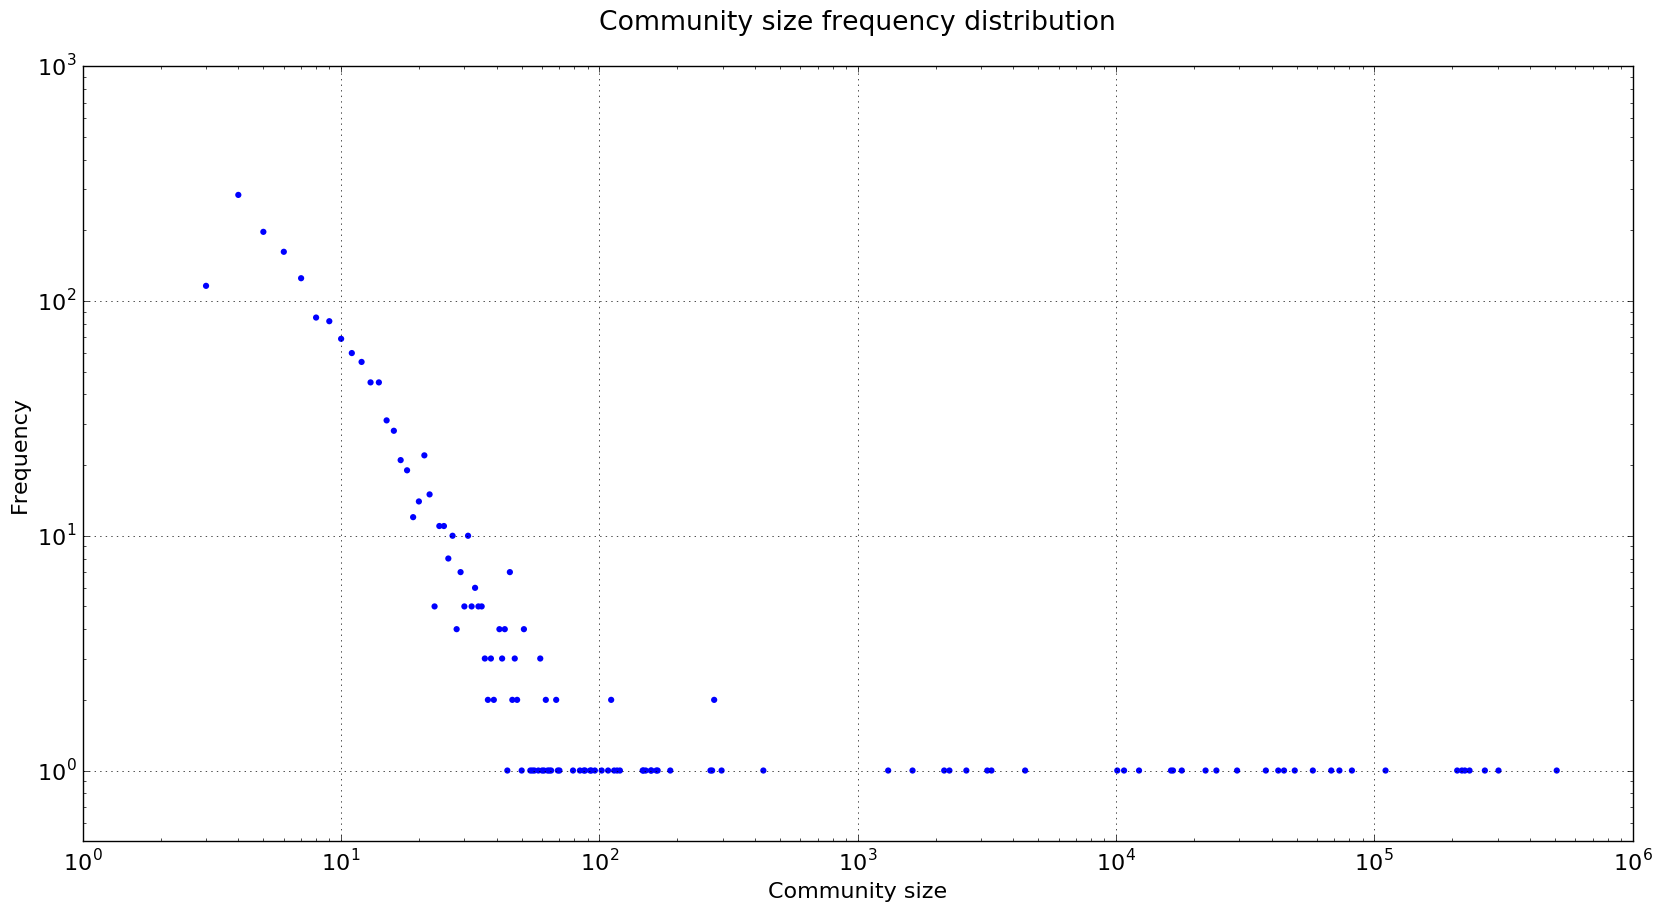

In [87]:
# Plot community sizes distribution

plt.scatter(louvain_communities.articles_count.value_counts().index,
            louvain_communities.articles_count.value_counts().values, 
            c="b", edgecolors='none')
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
plt.yscale("log")
ax.set_ylim(ymin=0.5)

    
plt.xlabel('Community size')
plt.ylabel('Frequency')
plt.grid(True)
plt.title("Community size frequency distribution\n");

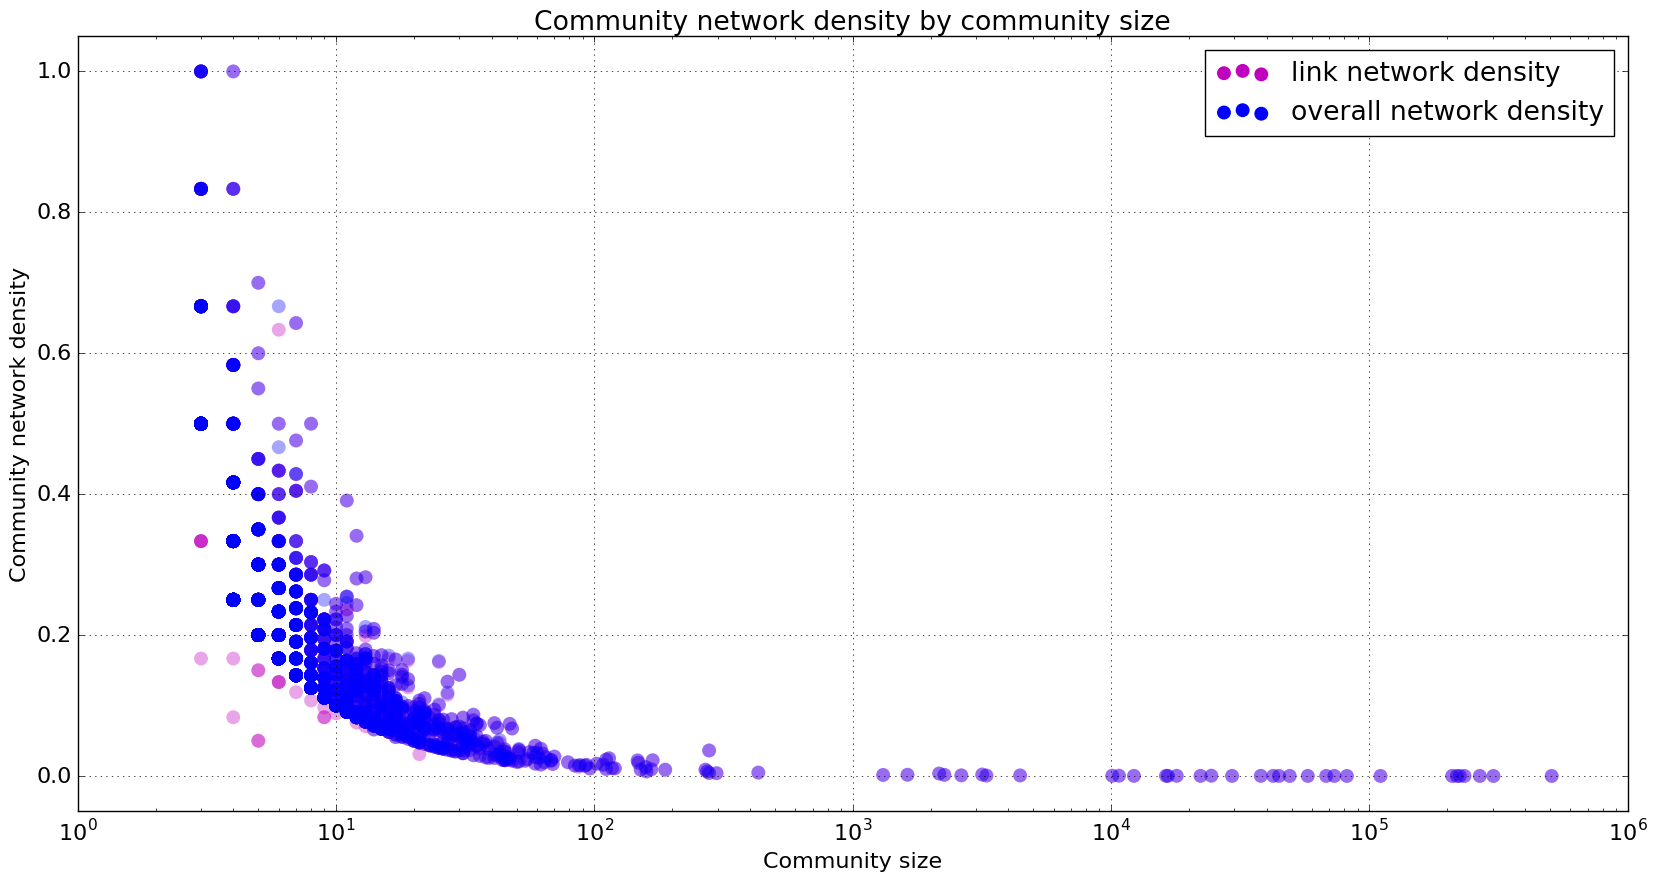

In [104]:
plt.scatter(louvain_communities.articles_count,
            louvain_communities.link_network_density, s=100, c="m", edgecolors='none', 
            alpha=0.35, label="link network density")

plt.scatter(louvain_communities.articles_count,
            louvain_communities.network_density, s=100, c="b", edgecolors='none', 
            alpha=0.35, label="overall network density")
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
#plt.yscale("log")
ax.set_ylim(ymin=-0.05, ymax = 1.05)

plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)
    
plt.xlabel('Community size')
plt.ylabel('Community network density')
plt.grid(True)
plt.title("Community network density by community size");

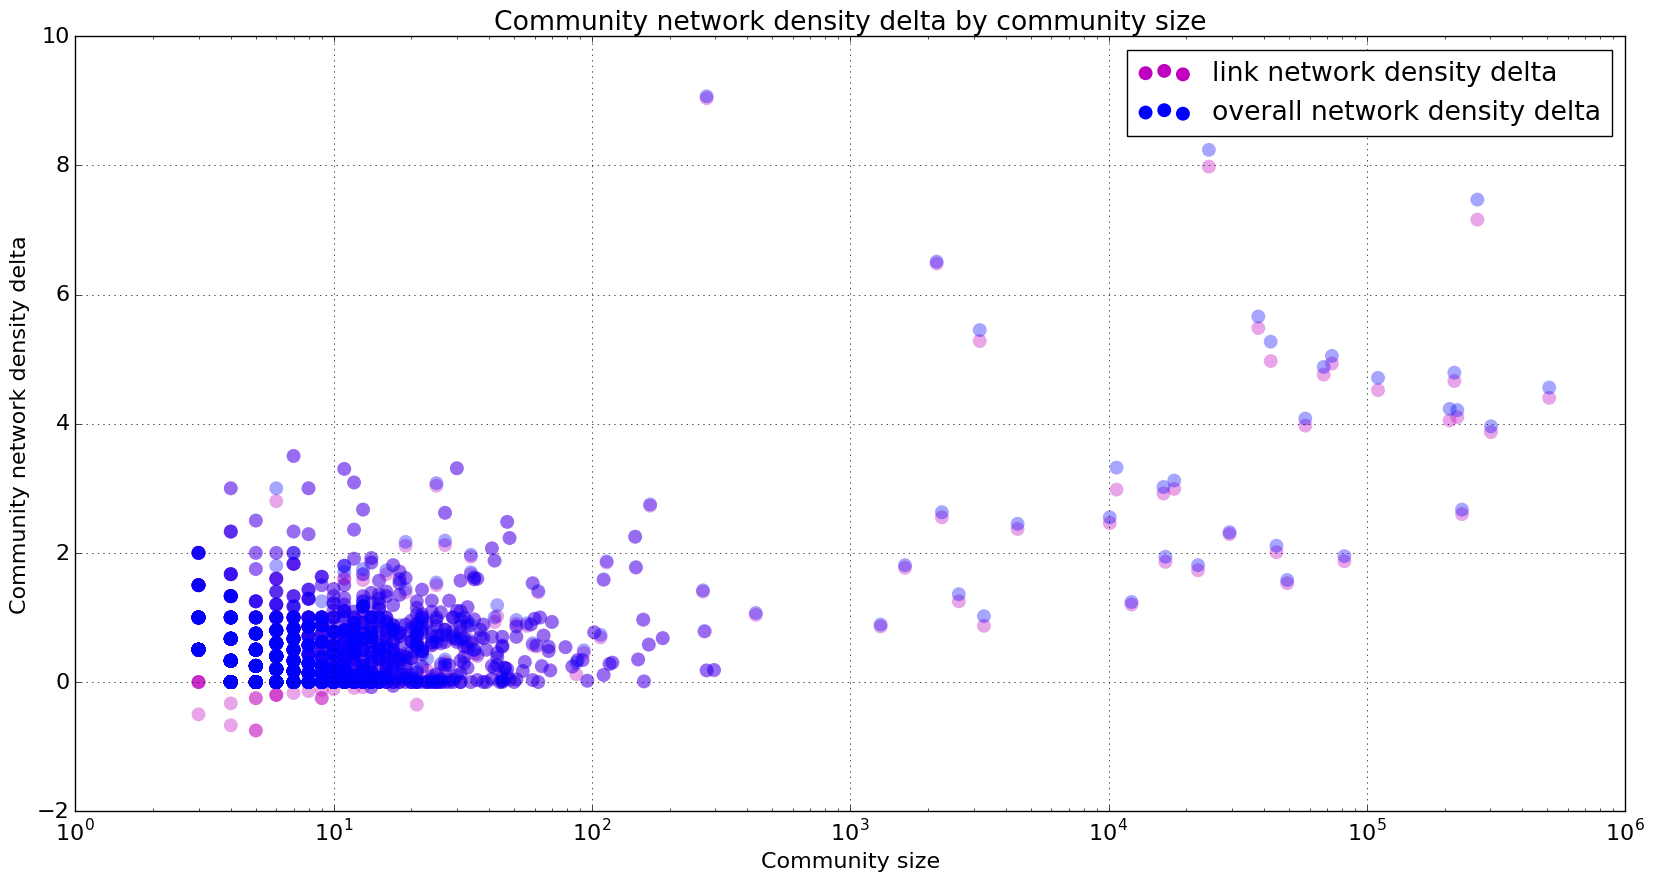

In [89]:
plt.scatter(louvain_communities.articles_count,
            louvain_communities.link_network_density_delta.round(2), s=100, c="m", edgecolors='none', 
            alpha=0.35, label="link network density delta")

plt.scatter(louvain_communities.articles_count,
            louvain_communities.network_density_delta.round(2), s=100, c="b", edgecolors='none', 
            alpha=0.35, label="overall network density delta")
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
#ax.set_ylim(ymin=0)

plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)
    
plt.xlabel('Community size')
plt.ylabel('Community network density delta')
plt.grid(True)
plt.title("Community network density delta by community size");

In [68]:
louvain_communities[louvain_communities.link_network_density_delta < 0].sort_values("link_network_density_delta")

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic,avg_external_search_traffic,avg_overall_link_in_degree,avg_community_link_in_degree,avg_link_in_traffic_per_edge,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta
1258,5,3087,2,50,1489,3,94,4005,1,26,3.00,94.00,617.40,0.40,0.20,25.00,26.00,801.00,0.05,-0.75,0.20,0.00
1158,5,1256,1,24,841,4,47,1989,1,24,3.00,35.00,251.20,0.20,0.20,24.00,24.00,397.80,0.05,-0.75,0.20,0.00
1319,4,99,2,184,386,2,25,819,1,17,2.00,25.00,24.75,0.50,0.25,92.00,17.00,204.75,0.08,-0.67,0.25,0.00
1620,3,829,2,35,1016,2,25,1206,1,14,2.00,25.00,276.33,0.67,0.33,17.50,14.00,402.00,0.17,-0.50,0.50,0.50
229,21,6145,16,359,211,12,206,10014,13,258,11.00,186.00,292.62,0.76,0.62,22.44,19.85,476.86,0.03,-0.35,0.06,0.20
1404,4,1241,2,30,1093,1,18,1537,2,30,1.00,18.00,310.25,0.50,0.50,15.00,15.00,384.25,0.17,-0.33,0.25,0.00
1167,5,203,4,519,888,2,43,1008,3,67,1.00,10.00,40.60,0.80,0.60,129.75,22.33,201.60,0.15,-0.25,0.20,0.00
1247,5,524,4,60,1428,1,14,968,3,46,1.00,14.00,104.80,0.80,0.60,15.00,15.33,193.60,0.15,-0.25,0.20,0.00
680,9,1571,7,118,618,2,29,2538,6,106,2.00,29.00,174.56,0.78,0.67,16.86,17.67,282.00,0.08,-0.25,0.11,0.00
685,9,742,9,208,670,3,74,1424,6,124,3.00,74.00,82.44,1.00,0.67,23.11,20.67,158.22,0.08,-0.25,0.12,0.13


##### Interesting communities from the above: 
211 - music of Uzbekisan and banks of Tajikistan  
841 - Polish soap opera actresses  
1489 - Indian artists  

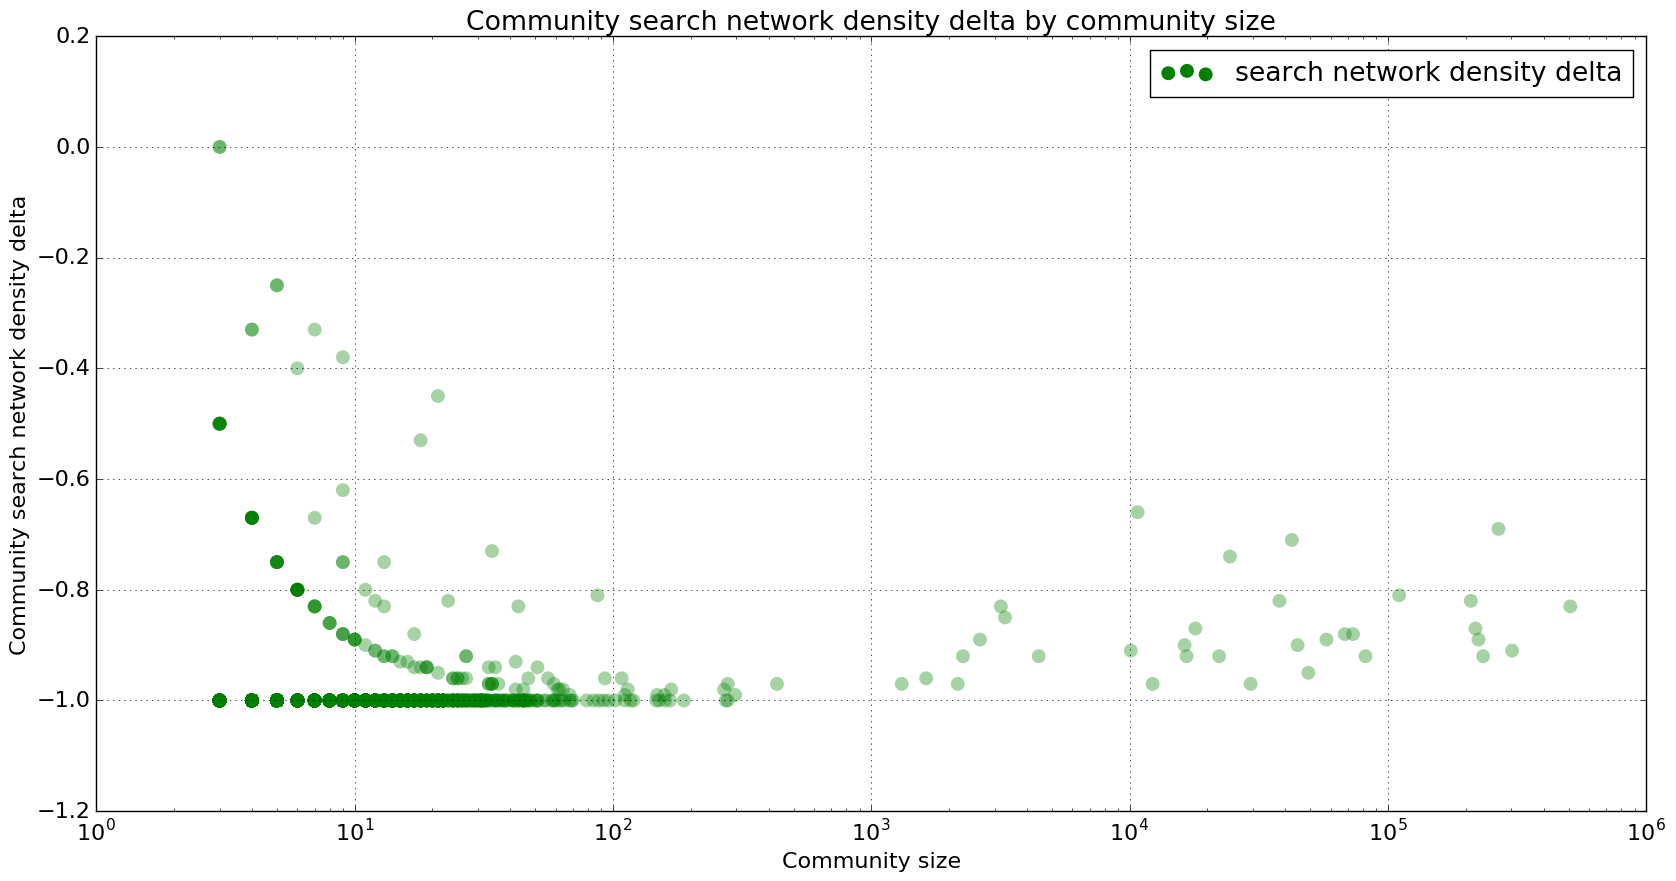

In [73]:
# Plot search network density deltas

plt.scatter(louvain_communities.articles_count,
            (louvain_communities.network_density_delta - louvain_communities.link_network_density_delta - 1).round(2), 
            s=100, c="g", edgecolors='none', alpha=0.35, label="search network density delta")
ax = plt.gca()
#ax.set_xlim(xmin=0)
plt.xscale("log")
#ax.set_ylim(ymin=0)

plt.legend()

# make the legend markers opaque
for lh in plt.gca().legend().legendHandles:
    lh.set_alpha(1)
    
plt.xlabel('Community size')
plt.ylabel('Community search network density delta')
plt.grid(True)
plt.title("Community search network density delta by community size");

In [107]:
louvain_communities["search_network_density_delta"] = \
    louvain_communities.network_density_delta - louvain_communities.link_network_density_delta - 1

In [110]:
louvain_communities[louvain_communities.search_network_density_delta > -0.5] \
    .sort_values("search_network_density_delta", ascending=False)

,articles_count,external_search_traffic,link_in_edges_count,link_in_traffic,louvain_community,search_in_edges_count,search_in_traffic,total_visits,link_edges_count,link_traffic,search_edges_count,search_traffic,avg_external_search_traffic,avg_overall_link_in_degree,avg_community_link_in_degree,avg_link_in_traffic_per_edge,avg_link_traffic_per_edge,avg_visits_per_article,link_network_density,link_network_density_delta,network_density,network_density_delta,search_network_density_delta
1595,3,1110,4,164,615,2,38,2161,4,164,2.00,38.00,370.00,1.33,1.33,41.00,41.00,720.33,0.67,1.00,1.00,2.00,0.00
1620,3,829,2,35,1016,2,25,1206,1,14,2.00,25.00,276.33,0.67,0.33,17.50,14.00,402.00,0.17,-0.50,0.50,0.50,0.00
1158,5,1256,1,24,841,4,47,1989,1,24,3.00,35.00,251.20,0.20,0.20,24.00,24.00,397.80,0.05,-0.75,0.20,0.00,-0.25
1258,5,3087,2,50,1489,3,94,4005,1,26,3.00,94.00,617.40,0.40,0.20,25.00,26.00,801.00,0.05,-0.75,0.20,0.00,-0.25
817,7,536,12,237,147,4,53,1809,9,190,4.00,53.00,76.57,1.71,1.29,19.75,21.11,258.43,0.21,0.50,0.31,1.17,-0.33
1319,4,99,2,184,386,2,25,819,1,17,2.00,25.00,24.75,0.50,0.25,92.00,17.00,204.75,0.08,-0.67,0.25,0.00,-0.33
1568,4,1158,3,37,1661,2,38,2382,3,37,2.00,38.00,289.50,0.75,0.75,12.33,12.33,595.50,0.25,0.00,0.42,0.67,-0.33
715,9,2098,14,655,1165,5,93,4141,13,644,5.00,93.00,233.11,1.56,1.44,46.79,49.54,460.11,0.18,0.62,0.25,1.25,-0.38
1077,6,1410,6,175,1431,4,117,2311,4,147,3.00,65.00,235.00,1.00,0.67,29.17,36.75,385.17,0.13,-0.20,0.23,0.40,-0.40
229,21,6145,16,359,211,12,206,10014,13,258,11.00,186.00,292.62,0.76,0.62,22.44,19.85,476.86,0.03,-0.35,0.06,0.20,-0.45


##### Deriving a network of communities  

Let's make a network of communities to see how interconnected they are.

In [117]:
# Get inter-community counts of LINK_TO edges

s = """MATCH (a1:Article)-[r:LINK_TO]->(a2:Article)
       WHERE a1.louvain_community <> a2.louvain_community
       RETURN 
            a1.louvain_community as from_lc_id, 
            a2.louvain_community as to_lc_id, 
            count(r) as link_edges_count,
            sum(r.traffic) as link_traffic;"""

with open("cypher_scripts/inter_community_link_edges.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/inter_community_link_edges.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/inter_community_link_edges.out
```
_runtime: 1 min_


In [118]:
! head cypher_scripts/inter_community_link_edges.out

from_lc_id, to_lc_id, link_edges_count, link_traffic
8, 1, 21717, 1067594
3, 1, 62506, 3543666
7, 1, 55577, 3014753
7, 2, 51982, 3602338
10, 2, 28916, 2237781
4, 2, 45969, 7302780
5, 4, 70448, 9931781
7, 4, 56477, 5441323
1, 4, 16836, 1557671


In [119]:
! sed -i 's/ //g' cypher_scripts/inter_community_link_edges.out

In [120]:
! head cypher_scripts/inter_community_link_edges.out

from_lc_id,to_lc_id,link_edges_count,link_traffic
8,1,21717,1067594
3,1,62506,3543666
7,1,55577,3014753
7,2,51982,3602338
10,2,28916,2237781
4,2,45969,7302780
5,4,70448,9931781
7,4,56477,5441323
1,4,16836,1557671


In [121]:
inter_community_link_edges = pd.read_csv("cypher_scripts/inter_community_link_edges.out")
print(len(inter_community_link_edges))
inter_community_link_edges.head()

5467


,from_lc_id,to_lc_id,link_edges_count,link_traffic
0,8,1,21717,1067594
1,3,1,62506,3543666
2,7,1,55577,3014753
3,7,2,51982,3602338
4,10,2,28916,2237781


In [111]:
# Get inter-community counts of SEARCH_FOR edges

s = """MATCH (a1:Article)-[r:SEARCH_FOR]->(a2:Article)
       WHERE a1.louvain_community <> a2.louvain_community
       RETURN 
            a1.louvain_community as from_lc_id, 
            a2.louvain_community as to_lc_id, 
            count(r) as search_edges_count,
            sum(r.traffic) as search_traffic;"""

with open("cypher_scripts/inter_community_search_edges.cypher", "w") as f:
    f.write(s)

Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/inter_community_search_edges.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/inter_community_search_edges.out
```
_runtime: <1 min_


In [113]:
! head cypher_scripts/inter_community_search_edges.out

from_lc_id, to_lc_id, search_edges_count, search_traffic
7, 3, 3596, 86630
22, 4, 144, 2745
2, 4, 1044, 32692
14, 7, 10, 190
10, 7, 701, 21548
4, 7, 3571, 141982
15, 24, 18, 592
25, 11, 14, 445
15, 10, 71, 1868


In [114]:
! sed -i 's/ //g' cypher_scripts/inter_community_search_edges.out

In [115]:
! head cypher_scripts/inter_community_search_edges.out

from_lc_id,to_lc_id,search_edges_count,search_traffic
7,3,3596,86630
22,4,144,2745
2,4,1044,32692
14,7,10,190
10,7,701,21548
4,7,3571,141982
15,24,18,592
25,11,14,445
15,10,71,1868


In [116]:
inter_community_search_edges = pd.read_csv("cypher_scripts/inter_community_search_edges.out")
print(len(inter_community_search_edges))
inter_community_search_edges.head()

976


,from_lc_id,to_lc_id,search_edges_count,search_traffic
0,7,3,3596,86630
1,22,4,144,2745
2,2,4,1044,32692
3,14,7,10,190
4,10,7,701,21548


The communities network is an abstraction if the clickstream graph, and since it is much smaller in size, we can visualize it in D3.  


##### Get top 5 most viewed articles for each community

In [64]:
len(louvain_communities)

1698

In [32]:
s = ""
for i in range(len(louvain_communities)):
    s += """ MATCH (a:Article)
        WHERE a.louvain_community = """ + str(i) + """
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            ( coalesce(a.external_website_traffic, 0)
            + coalesce(a.search_in_traffic, 0)
            + coalesce(a.search_traffic_from_main_page, 0)
            + coalesce(a.link_in_traffic, 0)
            + coalesce(a.unknown_external_traffic, 0)
            + coalesce(a.external_search_traffic, 0)
            + coalesce(a.empty_referer_traffic, 0)
            + coalesce(a.other_wikimedia_traffic, 0)) as total_visits
        ORDER BY coalesce(total_visits, 0) desc
        LIMIT 5;\n\n"""

In [33]:
print(s[:1000])

 MATCH (a:Article)
        WHERE a.louvain_community = 0
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            ( coalesce(a.external_website_traffic, 0)
            + coalesce(a.search_in_traffic, 0)
            + coalesce(a.search_traffic_from_main_page, 0)
            + coalesce(a.link_in_traffic, 0)
            + coalesce(a.unknown_external_traffic, 0)
            + coalesce(a.external_search_traffic, 0)
            + coalesce(a.empty_referer_traffic, 0)
            + coalesce(a.other_wikimedia_traffic, 0)) as total_visits
        ORDER BY coalesce(total_visits, 0) desc
        LIMIT 5;

 MATCH (a:Article)
        WHERE a.louvain_community = 1
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            ( coalesce(a.external_website_traffic, 0)
            + coalesce(a.search_in_traffic, 0)
            + coalesce(a.search_traffic_from_main_page, 0)
            + coalesce(a.

In [36]:
with open("cypher_scripts/community_top_viewed_articles.cypher", "w") as f:
    f.write(s)

In [40]:
!head -20 cypher_scripts/community_top_viewed_articles.cypher

 MATCH (a:Article)
        WHERE a.louvain_community = 0
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            ( coalesce(a.external_website_traffic, 0)
            + coalesce(a.search_in_traffic, 0)
            + coalesce(a.search_traffic_from_main_page, 0)
            + coalesce(a.link_in_traffic, 0)
            + coalesce(a.unknown_external_traffic, 0)
            + coalesce(a.external_search_traffic, 0)
            + coalesce(a.empty_referer_traffic, 0)
            + coalesce(a.other_wikimedia_traffic, 0)) as total_visits
        ORDER BY coalesce(total_visits, 0) desc
        LIMIT 5;

 MATCH (a:Article)
        WHERE a.louvain_community = 1
        RETURN 
            a.louvain_community as louvain_community,


Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_top_viewed_articles.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_top_viewed_articles.out
```
_runtime: a few hours_


In [43]:
print("Started running at", datetime.now(), "UTC")

Started running at 2019-03-22 03:57:50.201069 UTC


In [45]:
!head -20 cypher_scripts/community_top_viewed_articles.out

louvain_community, title, total_visits
0, "List_of_preserved_steam_locomotives_in_Germany", 186367
0, "Pink_Line_(Delhi_Metro)", 129412
0, "Marşandiz_train_collision", 92974
0, "Walt_Disney_World", 92144
0, "Disneyland", 90033
louvain_community, title, total_visits
1, "Main_Page", 504978470
1, "Hyphen-minus", 37581245
1, "XHamster", 4354947
1, "Elon_Musk", 1128932
1, "YouTube", 1116939
louvain_community, title, total_visits
2, "Jeffrey_Dahmer", 427912
2, "List_of_Presidents_of_the_United_States_by_date_of_death", 411055
2, "David_Attenborough", 381234
2, "Sexual_intercourse", 356219
2, "Caitlyn_Jenner", 355073
louvain_community, title, total_visits
3, "George_H._W._Bush", 6891439


In [85]:
!tail cypher_scripts/community_top_viewed_articles.out

louvain_community, title, total_visits
1696, "Peter_Goodfellow_(politician)", 308
1696, "Douglas_Goodfellow", 97
1696, "William_Goodfellow_(philanthropist)", 61
louvain_community, title, total_visits
1697, "Young_Galaxy", 448
1697, "Shapeshifting_(Young_Galaxy_album)", 145
1697, "Ultramarine_(album)", 64
1697, "Young_Galaxy_(album)", 44
1697, "Invisible_Republic_(album)", 25


##### Get top 5 influencer articles for each community  
This measure answers: Which key articles hold the specified community together?

There are many ways to define infuencer nodes. Here, we'll use **unweighted** degrees, restricted to articles within each community, as a simple measure of article influence inside each community. This influencer measure is meant to reflect the reach of an article within the specified community.  

In [66]:
s = ""
for i in range(len(louvain_communities)):
    s += """ MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = """ + str(i) + """ 
            AND b.louvain_community = """ + str(i) + """ 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;\n\n"""

In [67]:
print(s[:1000])

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 0 
            AND b.louvain_community = 0 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1 
            AND b.louvain_community = 1 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 2 
            AND b.louvain_community = 2 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 3 
     

In [68]:
with open("cypher_scripts/community_top_influencer_articles.cypher", "w") as f:
    f.write(s)

In [69]:
!head -20 cypher_scripts/community_top_influencer_articles.cypher

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 0 
            AND b.louvain_community = 0 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1 
            AND b.louvain_community = 1 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;



Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_top_influencer_articles.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_top_influencer_articles.out
```
_runtime: a few hours_


In [86]:
!head -20 cypher_scripts/community_top_influencer_articles.out

louvain_community, title, degree
0, "London_Underground", 382
0, "London_Overground", 265
0, "East_Coast_Main_Line", 263
0, "List_of_rail_accidents_in_the_United_Kingdom", 254
0, "Crossrail", 237
louvain_community, title, degree
1, "Android_(operating_system)", 1479
1, "Apple_Inc.", 1123
1, "Microsoft_Windows", 1116
1, "Google", 1072
1, "Earth", 1066
louvain_community, title, degree
2, "List_of_dinosaur_genera", 1169
2, "Animal", 1112
2, "Mammal", 960
2, "Taxonomy_(biology)", 893
2, "Aspirin", 859
louvain_community, title, degree
3, "India", 3131


In [96]:
!tail cypher_scripts/community_top_influencer_articles.out

1426, "In_Uncertain_Times", 2
1426, "On_the_Frontiers", 2
1426, "The_Time_Opener", 2
louvain_community, title, degree
1427, "List_of_Olympiacos_F.C._seasons", 5
1427, "2015–16_Olympiacos_F.C._season", 1
1427, "2018–19_Olympiacos_F.C._season", 1
1427, "2013–14_Olympiacos_F.C._season", 1
1427, "2014–15_Olympiacos_F.C._season", 1
The transaction has been terminated. Retry your operation in a new transaction, and you should see a successful result. Explicitly terminated by the user. 


The above script got interrupted while running. The below code picks up where it got interrupted.

In [89]:
start = 1428
s = ""
for i in range(start, len(louvain_communities)):
    s += """ MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = """ + str(i) + """ 
            AND b.louvain_community = """ + str(i) + """ 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;\n\n"""

In [90]:
print(s[:1000])

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1428 
            AND b.louvain_community = 1428 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1429 
            AND b.louvain_community = 1429 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1430 
            AND b.louvain_community = 1430 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_co

In [91]:
with open("cypher_scripts/community_top_influencer_articles_rerun.cypher", "w") as f:
    f.write(s)

In [92]:
!head -20 cypher_scripts/community_top_influencer_articles_rerun.cypher

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1428 
            AND b.louvain_community = 1428 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;

 MATCH (a:Article)-[r]-(b:Article)
        WHERE a.louvain_community = 1429 
            AND b.louvain_community = 1429 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            count(r) as degree
        ORDER BY coalesce(degree, 0) desc
        LIMIT 5;



Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_top_influencer_articles_rerun.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_top_influencer_articles_rerun.out
```


In [94]:
!head -20 cypher_scripts/community_top_influencer_articles_rerun.out

louvain_community, title, degree
1428, "National_Museum_of_Iceland", 3
1428, "Viking_World_museum", 2
1428, "Valþjófsstaður_door", 1
1428, "Reykjavik_Art_Museum", 1
1428, "List_of_museums_in_Iceland", 1
louvain_community, title, degree
1429, "Red_Devils_(film)", 4
1429, "Ivan_Perestiani", 2
1429, "Red_Devils_(story)", 1
1429, "The_Crime_of_Shirvanskaya", 1
louvain_community, title, degree
1430, "1997_New_Zealand_National_Party_leadership_election", 4
1430, "2001_New_Zealand_National_Party_leadership_election", 4
1430, "1986_New_Zealand_National_Party_leadership_election", 4
1430, "1984_New_Zealand_National_Party_leadership_election", 3
1430, "2003_New_Zealand_National_Party_leadership_election", 2
louvain_community, title, degree
1431, "Tomasz_Lis", 4
1431, "Katarzyna_Cichopek", 3


In [99]:
!tail cypher_scripts/community_top_influencer_articles_rerun.out

louvain_community, title, degree
1696, "Douglas_Goodfellow", 3
1696, "William_Goodfellow_(philanthropist)", 2
1696, "Peter_Goodfellow_(politician)", 1
louvain_community, title, degree
1697, "Young_Galaxy", 5
1697, "Young_Galaxy_(album)", 2
1697, "Shapeshifting_(Young_Galaxy_album)", 2
1697, "Invisible_Republic_(album)", 2
1697, "Ultramarine_(album)", 1


##### Get top 5 connector articles for each community   
This measure answers: Through which articles does traffic from other communities tend to get to the specified community?  

There are also many ways to define connector nodes. Here, we'll use traffic-**weighted** in-degrees, restricted to edges going from articles outside the specified community to articles within it, as a measure of how much inter-community traffic each article brings in to the community. This connector measure is meant to rank articles as entry points to the specified community.  

In [73]:
s = ""
for i in range(len(louvain_communities)):
    s += """ MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = """ + str(i) + """ 
            AND b.louvain_community <> """ + str(i) + """ 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;\n\n"""

In [74]:
print(s[:1000])

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 0 
            AND b.louvain_community <> 0 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1 
            AND b.louvain_community <> 1 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 2 
            AND b.louvain_community <> 2 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Arti

In [75]:
with open("cypher_scripts/community_top_connector_articles.cypher", "w") as f:
    f.write(s)

In [100]:
!head -20 cypher_scripts/community_top_connector_articles.cypher

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 0 
            AND b.louvain_community <> 0 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1 
            AND b.louvain_community <> 1 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;



Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_top_connector_articles.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_top_connector_articles.out
```
_runtime: a couple hours_


In [104]:
!head -20 cypher_scripts/community_top_connector_articles.out

louvain_community, title, in_traffic
0, "Disney_family", 50525
0, "Roy_O._Disney", 25238
0, "Listed_building", 15762
0, "Paul_Theroux", 11855
0, "Rapid_transit", 9253
louvain_community, title, in_traffic
1, "Elon_Musk", 125907
1, "YouTube", 111194
1, "Music_download", 80749
1, "Instagram", 69634
1, "Crore", 63898
louvain_community, title, in_traffic
2, "Lisa_Marie_Presley", 153345
2, "Caitlyn_Jenner", 128825
2, "Pansexuality", 113545
2, "Pneumonia", 95726
2, "Jennifer_Syme", 91587
louvain_community, title, in_traffic
3, "Priyanka_Chopra", 527036


In [123]:
!tail cypher_scripts/community_top_connector_articles.out

louvain_community, title, in_traffic
1444, "Simon_IV,_Lord_of_Lippe", 45
1444, "Heilwig_of_Lippe", 33
1444, "Herman_I,_Lord_of_Lippe", 12
louvain_community, title, in_traffic
1445, "Kya_Yahi_Sach_Hai", 10
louvain_community, title, in_traffic
1446, "Zamania_(Assembly_constituency)", 60
louvain_community, title, in_traffic
1447, "Henry_Bridgeman,_1st_Baron_Bradford", 45


The above script got interrupted while running. The below code picks up where it got interrupted.

In [117]:
start = 1448
s = ""
for i in range(start, len(louvain_communities)):
    s += """ MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = """ + str(i) + """ 
            AND b.louvain_community <> """ + str(i) + """ 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;\n\n"""

In [118]:
print(s[:1000])

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1448 
            AND b.louvain_community <> 1448 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1449 
            AND b.louvain_community <> 1449 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1450 
            AND b.louvain_community <> 1450 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Art

In [119]:
with open("cypher_scripts/community_top_connector_articles_rerun.cypher", "w") as f:
    f.write(s)

In [120]:
!head -20 cypher_scripts/community_top_connector_articles_rerun.cypher

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1448 
            AND b.louvain_community <> 1448 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;

 MATCH (a:Article)<-[r]-(b:Article)
        WHERE a.louvain_community = 1449 
            AND b.louvain_community <> 1449 
        RETURN 
            a.louvain_community as louvain_community,
            a.title as title, 
            sum(r.traffic) as in_traffic
        ORDER BY coalesce(in_traffic, 0) desc
        LIMIT 5;



Run the above cypher script in terminal with nohup:  
```
passwd=$(bash get_n4j_pass.sh)
nohup cat cypher_scripts/community_top_connector_articles_rerun.cypher | cypher-shell -u neo4j -p $passwd --format plain &> cypher_scripts/community_top_connector_articles_rerun.out
```


In [62]:
# compare the output files modification times to estimate run times

In [126]:
!head -20 cypher_scripts/community_top_connector_articles_rerun.out

louvain_community, title, in_traffic
1448, "G._P._Taylor", 233
1448, "Shadowmancer", 28
1448, "Wormwood_(Taylor_novel)", 10
louvain_community, title, in_traffic
1449, "Alison_Rose", 46
1449, "Michael_Aron", 28

louvain_community, title, in_traffic
1451, "Turgay_Oblast_(Russian_Empire)", 11
louvain_community, title, in_traffic
1452, "Andrey_Bartenev", 279
louvain_community, title, in_traffic
1453, "1946_Soviet_Union_legislative_election", 171
1453, "1979_Soviet_Union_legislative_election", 93

louvain_community, title, in_traffic
1455, "The_Singing_Kettle", 84
1455, "Kingskettle", 15
louvain_community, title, in_traffic


In [129]:
!tail cypher_scripts/community_top_connector_articles_rerun.out


louvain_community, title, in_traffic
1694, "Minken_Fosheim", 15
1694, "The_Monroes", 13
louvain_community, title, in_traffic
1695, "The_65_Lakh_Heist", 10
louvain_community, title, in_traffic
1696, "Peter_Goodfellow_(politician)", 164
louvain_community, title, in_traffic
1697, "Shapeshifting_(Young_Galaxy_album)", 46


### 4. Summary   

In this notebook, we've described the English Wikipedia clickstream graph structure, identified influential articles and found topic-based article clusters using Louvain community detection.

### 5. Next steps  

We've found interesting communities of Wikipedia articles in the clickstream graph, and they appear to be clustered by topics. In the [next notebook](English_Wikipedia_NLP_AWS.ipynb) we'll use simple NLP techniques to extract community topics.